# Weather and collision data analysis

## Initial import

In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point, MultiPolygon, Polygon

from sklearn.tree import DecisionTreeClassifier as DT
from sklearn.ensemble import RandomForestClassifier as RF
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn import metrics
from sklearn.metrics import confusion_matrix, accuracy_score





In [3]:
pd.set_option('display.max_columns', None)

In [5]:
crash21 = pd.read_csv("dft-road-casualty-statistics-collision-2021.csv")

C:\Users\admin\AppData\Local\Temp\ipykernel_20648\3077528225.py:1: DtypeWarning: Columns (0,2,35) have mixed types. Specify dtype option on import or set low_memory=False.
  crash21 = pd.read_csv("dft-road-casualty-statistics-collision-2021.csv")


In [6]:
crash22 = pd.read_csv("dft-road-casualty-statistics-collision-2022.csv")

C:\Users\admin\AppData\Local\Temp\ipykernel_20648\1311626502.py:1: DtypeWarning: Columns (0,2) have mixed types. Specify dtype option on import or set low_memory=False.
  crash22 = pd.read_csv("dft-road-casualty-statistics-collision-2022.csv")


In [7]:
crash = pd.concat([crash21, crash22])

In [9]:
crash.head(2)

,accident_index,accident_year,accident_reference,location_easting_osgr,location_northing_osgr,longitude,latitude,police_force,accident_severity,number_of_vehicles,number_of_casualties,date,day_of_week,time,local_authority_district,local_authority_ons_district,local_authority_highway,first_road_class,first_road_number,road_type,speed_limit,junction_detail,junction_control,second_road_class,second_road_number,pedestrian_crossing_human_control,pedestrian_crossing_physical_facilities,light_conditions,weather_conditions,road_surface_conditions,special_conditions_at_site,carriageway_hazards,urban_or_rural_area,did_police_officer_attend_scene_of_accident,trunk_road_flag,lsoa_of_accident_location
0,2021010287148,2021,10287148,521508.0,193079.0,-0.246102,51.623425,1,3,3,1,01/01/2021,6,02:05,-1,E09000003,E09000003,6,0,6,30,9,4,6,0,0,0,4,7,4,1,0,1,1,2,E01000263
1,2021010287149,2021,10287149,535379.0,180783.0,-0.050574,51.509767,1,2,2,3,01/01/2021,6,03:30,-1,E09000030,E09000030,3,1203,3,30,7,2,3,1204,0,5,4,1,1,0,0,1,1,2,E01004303


In [10]:
crash.shape

(207091, 36)

In [11]:
weather = pd.read_csv("Bristol 2021-01-01 to 2022-12-31.csv")

In [12]:
weather.head(2)

,datetime,tempmax,tempmin,temp,feelslikemax,feelslikemin,feelslike,dew,humidity,precip,precipprob,precipcover,preciptype,snow,snowdepth,windgust,windspeed,winddir,sealevelpressure,cloudcover,visibility,solarradiation,solarenergy,uvindex,sunrise,sunset,moonphase,conditions,description,icon
0,2021-01-01,3.0,-1.3,1.1,0.0,-3.2,-1.2,0.3,94.6,0.326,100,8.33,"rain,snow",0.0,0.0,26.3,14.5,348.0,1012.0,74.3,10.3,314.2,27.2,1,2021-01-01T08:15:50,2021-01-01T16:12:30,0.58,"Snow, Rain, Partially cloudy",Partly cloudy throughout the day with rain or ...,rain
1,2021-01-02,3.0,-1.0,1.1,1.0,-5.4,-1.9,-0.1,91.8,0.681,100,12.50,"rain,snow",0.0,0.0,24.8,21.4,337.1,1016.4,64.6,11.2,146.0,12.6,2,2021-01-02T08:15:41,2021-01-02T16:13:35,0.62,"Snow, Rain, Partially cloudy",Partly cloudy throughout the day with rain or ...,rain


In [13]:
weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 730 entries, 0 to 729
Data columns (total 30 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   datetime          730 non-null    object 
 1   tempmax           730 non-null    float64
 2   tempmin           730 non-null    float64
 3   temp              730 non-null    float64
 4   feelslikemax      730 non-null    float64
 5   feelslikemin      730 non-null    float64
 6   feelslike         730 non-null    float64
 7   dew               730 non-null    float64
 8   humidity          730 non-null    float64
 9   precip            730 non-null    float64
 10  precipprob        730 non-null    int64  
 11  precipcover       730 non-null    float64
 12  preciptype        528 non-null    object 
 13  snow              730 non-null    float64
 14  snowdepth         730 non-null    float64
 15  windgust          730 non-null    float64
 16  windspeed         730 non-null    float64
 1

## Using Geopandas to filter out everything but Bristol

In [22]:
# pip install geopandas

In [24]:
gdf_crash = gpd.GeoDataFrame(crash, geometry=gpd.points_from_xy(crash.longitude, crash.latitude), crs="EPSG:4326")

In [25]:
gdf_crash.head(2)

,accident_index,accident_year,accident_reference,location_easting_osgr,location_northing_osgr,longitude,latitude,police_force,accident_severity,number_of_vehicles,number_of_casualties,date,day_of_week,time,local_authority_district,local_authority_ons_district,local_authority_highway,first_road_class,first_road_number,road_type,speed_limit,junction_detail,junction_control,second_road_class,second_road_number,pedestrian_crossing_human_control,pedestrian_crossing_physical_facilities,light_conditions,weather_conditions,road_surface_conditions,special_conditions_at_site,carriageway_hazards,urban_or_rural_area,did_police_officer_attend_scene_of_accident,trunk_road_flag,lsoa_of_accident_location,geometry
0,2021010287148,2021,10287148,521508.0,193079.0,-0.246102,51.623425,1,3,3,1,01/01/2021,6,02:05,-1,E09000003,E09000003,6,0,6,30,9,4,6,0,0,0,4,7,4,1,0,1,1,2,E01000263,POINT (-0.2461 51.62342)
1,2021010287149,2021,10287149,535379.0,180783.0,-0.050574,51.509767,1,2,2,3,01/01/2021,6,03:30,-1,E09000030,E09000030,3,1203,3,30,7,2,3,1204,0,5,4,1,1,0,0,1,1,2,E01004303,POINT (-0.05057 51.50977)


In [26]:
counties_gdf = gpd.read_file("CTYUA_MAY_2023_UK_BGC.shp") #loading the shapefile for the UK

counties_gdf[counties_gdf['CTYUA23NM']=='Bristol, City of']

,CTYUA23CD,CTYUA23NM,CTYUA23NMW,BNG_E,BNG_N,LONG,LAT,GlobalID,geometry
22,E06000023,"Bristol, City of",None,359990,174846,-2.57742,51.4711,33dd4cff-e9e4-4411-b76d-c96e64e08745,"MULTIPOLYGON (((352770.519 175989.663, 352895...."


In [28]:
# counties_gdf.plot(markersize=.5)

In [29]:
bristol = counties_gdf[counties_gdf['CTYUA23NM']=='Bristol, City of']['geometry']

<Axes: >

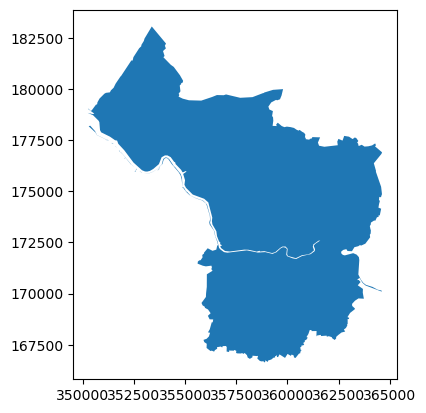

In [30]:
bristol.plot()

In [31]:
type(bristol)

geopandas.geoseries.GeoSeries

In [33]:
bristol

22    MULTIPOLYGON (((352770.519 175989.663, 352895....
Name: geometry, dtype: geometry

### Converting to British National Grid references

In [41]:
gdf_crash['BNG'] = gdf_crash['geometry'].to_crs(epsg=27700)

In [42]:
gdf_crash.head(1)

,accident_index,accident_year,accident_reference,location_easting_osgr,location_northing_osgr,longitude,latitude,police_force,accident_severity,number_of_vehicles,number_of_casualties,date,day_of_week,time,local_authority_district,local_authority_ons_district,local_authority_highway,first_road_class,first_road_number,road_type,speed_limit,junction_detail,junction_control,second_road_class,second_road_number,pedestrian_crossing_human_control,pedestrian_crossing_physical_facilities,light_conditions,weather_conditions,road_surface_conditions,special_conditions_at_site,carriageway_hazards,urban_or_rural_area,did_police_officer_attend_scene_of_accident,trunk_road_flag,lsoa_of_accident_location,geometry,BNG
0,2021010287148,2021,10287148,521508.0,193079.0,-0.246102,51.623425,1,3,3,1,01/01/2021,6,02:05,-1,E09000003,E09000003,6,0,6,30,9,4,6,0,0,0,4,7,4,1,0,1,1,2,E01000263,POINT (-0.2461 51.62342),POINT (521509.659 193079.41)


In [43]:
def in_bris(p):
    return p.within(bristol)

In [44]:
gdf_crash['in_bristol'] = gdf_crash['BNG'].apply(in_bris)

In [45]:
gdf_crash.head(1)

,accident_index,accident_year,accident_reference,location_easting_osgr,location_northing_osgr,longitude,latitude,police_force,accident_severity,number_of_vehicles,number_of_casualties,date,day_of_week,time,local_authority_district,local_authority_ons_district,local_authority_highway,first_road_class,first_road_number,road_type,speed_limit,junction_detail,junction_control,second_road_class,second_road_number,pedestrian_crossing_human_control,pedestrian_crossing_physical_facilities,light_conditions,weather_conditions,road_surface_conditions,special_conditions_at_site,carriageway_hazards,urban_or_rural_area,did_police_officer_attend_scene_of_accident,trunk_road_flag,lsoa_of_accident_location,geometry,BNG,in_bristol
0,2021010287148,2021,10287148,521508.0,193079.0,-0.246102,51.623425,1,3,3,1,01/01/2021,6,02:05,-1,E09000003,E09000003,6,0,6,30,9,4,6,0,0,0,4,7,4,1,0,1,1,2,E01000263,POINT (-0.2461 51.62342),POINT (521509.659 193079.41),False


In [46]:
bris_gdf_crash = gdf_crash[gdf_crash['in_bristol']==True]

In [47]:
bris_gdf_crash.shape

(1705, 39)

In [48]:
bris_gdf_crash.head(2)

,accident_index,accident_year,accident_reference,location_easting_osgr,location_northing_osgr,longitude,latitude,police_force,accident_severity,number_of_vehicles,number_of_casualties,date,day_of_week,time,local_authority_district,local_authority_ons_district,local_authority_highway,first_road_class,first_road_number,road_type,speed_limit,junction_detail,junction_control,second_road_class,second_road_number,pedestrian_crossing_human_control,pedestrian_crossing_physical_facilities,light_conditions,weather_conditions,road_surface_conditions,special_conditions_at_site,carriageway_hazards,urban_or_rural_area,did_police_officer_attend_scene_of_accident,trunk_road_flag,lsoa_of_accident_location,geometry,BNG,in_bristol
88997,2021522100028,2021,522100028,357448.0,174517.0,-2.613978,51.468010,52,3,2,1,04/01/2021,2,11:12,-1,E06000023,E06000023,6,0,6,20,0,-1,0,-1,0,0,1,9,2,0,0,1,2,2,E01014553,POINT (-2.61398 51.46801),POINT (357447.82 174516.895),True
88999,2021522100091,2021,522100091,360002.0,174663.0,-2.577227,51.469509,52,3,1,1,06/01/2021,4,12:25,-1,E06000023,E06000023,6,0,6,20,0,-1,0,-1,0,0,1,4,1,0,0,1,2,2,E01014486,POINT (-2.57723 51.46951),POINT (360001.952 174662.837),True


## Convert dates for joining

In [53]:
bris_gdf_crash['date'] = pd.to_datetime(bris_gdf_crash['date'], format='%d/%m/%Y') #this takes the dates in the current format of dd/mm/yyyy and turns them into standard datetime format of yyyy-mm-dd

C:\Users\admin\anaconda3\Lib\site-packages\geopandas\geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [54]:
weather['datetime'] = pd.to_datetime(weather['datetime'], format='%Y-%m-%d')

In [55]:
bris_gdf_crash[['date']].dtypes

date    datetime64[ns]
dtype: object

In [56]:
weather[['datetime']].head()

,datetime
0,2021-01-01
1,2021-01-02
2,2021-01-03
3,2021-01-04
4,2021-01-05


In [57]:
bris_gdf_crash[['date']].head()

,date
88997,2021-01-04
88999,2021-01-06
89000,2021-01-05
89002,2021-01-05
89003,2021-01-07


## Joining the dfs

In [70]:
weather.rename(columns = {'datetime':'date'}, inplace = True)

In [72]:
df = pd.merge(bris_gdf_crash, weather, on='date', how='left')

In [73]:
df.shape

(1705, 68)

## Basic cleaning of the DF

This stage of the process will just be a rudimental cleaning to remove obvious problems in the data.only.

In [78]:
df.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 1705 entries, 0 to 1704
Data columns (total 68 columns):
 #   Column                                       Non-Null Count  Dtype         
---  ------                                       --------------  -----         
 0   accident_index                               1705 non-null   object        
 1   accident_year                                1705 non-null   int64         
 2   accident_reference                           1705 non-null   object        
 3   location_easting_osgr                        1705 non-null   float64       
 4   location_northing_osgr                       1705 non-null   float64       
 5   longitude                                    1705 non-null   float64       
 6   latitude                                     1705 non-null   float64       
 7   police_force                                 1705 non-null   int64         
 8   accident_severity                            1705 non-null   int64    

In [79]:
df['time'] = pd.to_datetime(df['time'], format='%H:%M').dt.time #turns time into a datetime.time dtype

In [80]:
df[['date','time']].dtypes

date    datetime64[ns]
time            object
dtype: object

In [81]:
df[(df['preciptype'].isnull()==True) & (df['precip']!=0)][['date','precip','preciptype']]

,date,precip,preciptype


all nulls for the precip type occure when there is no precipitation type so I will fill the values with 'None'

In [83]:
df['preciptype'] = df['preciptype'].fillna("None")

In [86]:
df.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 1705 entries, 0 to 1704
Data columns (total 68 columns):
 #   Column                                       Non-Null Count  Dtype         
---  ------                                       --------------  -----         
 0   accident_index                               1705 non-null   object        
 1   accident_year                                1705 non-null   int64         
 2   accident_reference                           1705 non-null   object        
 3   location_easting_osgr                        1705 non-null   float64       
 4   location_northing_osgr                       1705 non-null   float64       
 5   longitude                                    1705 non-null   float64       
 6   latitude                                     1705 non-null   float64       
 7   police_force                                 1705 non-null   int64         
 8   accident_severity                            1705 non-null   int64    

Nulls have been taken care of so I will now undergo the process of deciding which columns are going to be of most use in this project. The first consideration is going to be which elements of the dataframe could lead to a collision rather than be a consequence of a collision e.g. which police force was present after the accident did not influence whether the collision took place. Next, which columns are redundant because other columns either summarise the same data or perhaps they simply don't add any useful information.

In [91]:
df.columns

Index(['accident_index', 'accident_year', 'accident_reference',
       'location_easting_osgr', 'location_northing_osgr', 'longitude',
       'latitude', 'police_force', 'accident_severity', 'number_of_vehicles',
       'number_of_casualties', 'date', 'day_of_week', 'time',
       'local_authority_district', 'local_authority_ons_district',
       'local_authority_highway', 'first_road_class', 'first_road_number',
       'road_type', 'speed_limit', 'junction_detail', 'junction_control',
       'second_road_class', 'second_road_number',
       'pedestrian_crossing_human_control',
       'pedestrian_crossing_physical_facilities', 'light_conditions',
       'weather_conditions', 'road_surface_conditions',
       'special_conditions_at_site', 'carriageway_hazards',
       'urban_or_rural_area', 'did_police_officer_attend_scene_of_accident',
       'trunk_road_flag', 'lsoa_of_accident_location', 'geometry', 'BNG',
       'in_bristol', 'tempmax', 'tempmin', 'temp', 'feelslikemax',
       'fee

In [92]:
df.head(2)

,accident_index,accident_year,accident_reference,location_easting_osgr,location_northing_osgr,longitude,latitude,police_force,accident_severity,number_of_vehicles,number_of_casualties,date,day_of_week,time,local_authority_district,local_authority_ons_district,local_authority_highway,first_road_class,first_road_number,road_type,speed_limit,junction_detail,junction_control,second_road_class,second_road_number,pedestrian_crossing_human_control,pedestrian_crossing_physical_facilities,light_conditions,weather_conditions,road_surface_conditions,special_conditions_at_site,carriageway_hazards,urban_or_rural_area,did_police_officer_attend_scene_of_accident,trunk_road_flag,lsoa_of_accident_location,geometry,BNG,in_bristol,tempmax,tempmin,temp,feelslikemax,feelslikemin,feelslike,dew,humidity,precip,precipprob,precipcover,preciptype,snow,snowdepth,windgust,windspeed,winddir,sealevelpressure,cloudcover,visibility,solarradiation,solarenergy,uvindex,sunrise,sunset,moonphase,conditions,description,icon
0,2021522100028,2021,522100028,357448.0,174517.0,-2.613978,51.468010,52,3,2,1,2021-01-04,2,11:12:00,-1,E06000023,E06000023,6,0,6,20,0,-1,0,-1,0,0,1,9,2,0,0,1,2,2,E01014553,POINT (-2.61398 51.46801),POINT (357447.82 174516.895),True,3.3,1.0,2.2,-1.9,-5.0,-3.2,0.7,90.5,0.0,0,0.0,None,0.0,0.0,54.4,31.3,33.6,1020.3,88.8,12.4,363.7,31.6,1,2021-01-04T08:15:15,2021-01-04T16:15:53,0.69,Partially cloudy,Partly cloudy throughout the day.,partly-cloudy-day
1,2021522100091,2021,522100091,360002.0,174663.0,-2.577227,51.469509,52,3,1,1,2021-01-06,4,12:25:00,-1,E06000023,E06000023,6,0,6,20,0,-1,0,-1,0,0,1,4,1,0,0,1,2,2,E01014486,POINT (-2.57723 51.46951),POINT (360001.952 174662.837),True,2.3,-1.0,1.0,-1.0,-5.8,-3.5,-0.1,92.3,0.0,0,0.0,None,0.0,0.0,38.9,25.9,28.0,1020.8,86.5,11.8,72.0,6.2,1,2021-01-06T08:14:35,2021-01-06T16:18:22,0.75,Partially cloudy,Partly cloudy throughout the day.,partly-cloudy-day


## EDA

In [96]:
len(df.accident_index.unique()) # this is a unique identifier so I can remove accident_reference

1705

In [98]:
indep_features = ['accident_index', 'longitude', 'latitude', 'date', 'day_of_week', 'time',
       'first_road_class', 'first_road_number',
       'road_type', 'speed_limit', 'junction_detail', 'junction_control',
       'second_road_class', 'second_road_number',
       'pedestrian_crossing_human_control',
       'pedestrian_crossing_physical_facilities', 'light_conditions',
       'weather_conditions', 'road_surface_conditions',
       'special_conditions_at_site', 'carriageway_hazards',
       'urban_or_rural_area', 'trunk_road_flag', 'tempmax',
       'tempmin', 'temp', 'feelslikemax', 'feelslikemin', 'feelslike', 'dew',
       'humidity', 'precip', 'precipprob', 'precipcover', 'preciptype', 'snow',
       'snowdepth', 'windgust', 'windspeed', 'winddir', 'sealevelpressure',
       'cloudcover', 'visibility', 'solarradiation', 'solarenergy', 'uvindex',
        'sunrise', 'sunset', 'moonphase', 'conditions', 'description', 'icon']

In [100]:
df2 = df[indep_features].copy()

In [102]:
df2.shape

(1705, 52)

In [104]:
df2.head(1)

,accident_index,longitude,latitude,date,day_of_week,time,first_road_class,first_road_number,road_type,speed_limit,junction_detail,junction_control,second_road_class,second_road_number,pedestrian_crossing_human_control,pedestrian_crossing_physical_facilities,light_conditions,weather_conditions,road_surface_conditions,special_conditions_at_site,carriageway_hazards,urban_or_rural_area,trunk_road_flag,tempmax,tempmin,temp,feelslikemax,feelslikemin,feelslike,dew,humidity,precip,precipprob,precipcover,preciptype,snow,snowdepth,windgust,windspeed,winddir,sealevelpressure,cloudcover,visibility,solarradiation,solarenergy,uvindex,sunrise,sunset,moonphase,conditions,description,icon
0,2021522100028,-2.613978,51.46801,2021-01-04,2,11:12:00,6,0,6,20,0,-1,0,-1,0,0,1,9,2,0,0,1,2,3.3,1.0,2.2,-1.9,-5.0,-3.2,0.7,90.5,0.0,0,0.0,None,0.0,0.0,54.4,31.3,33.6,1020.3,88.8,12.4,363.7,31.6,1,2021-01-04T08:15:15,2021-01-04T16:15:53,0.69,Partially cloudy,Partly cloudy throughout the day.,partly-cloudy-day


In [106]:
# df2.corr(numeric_only =True)

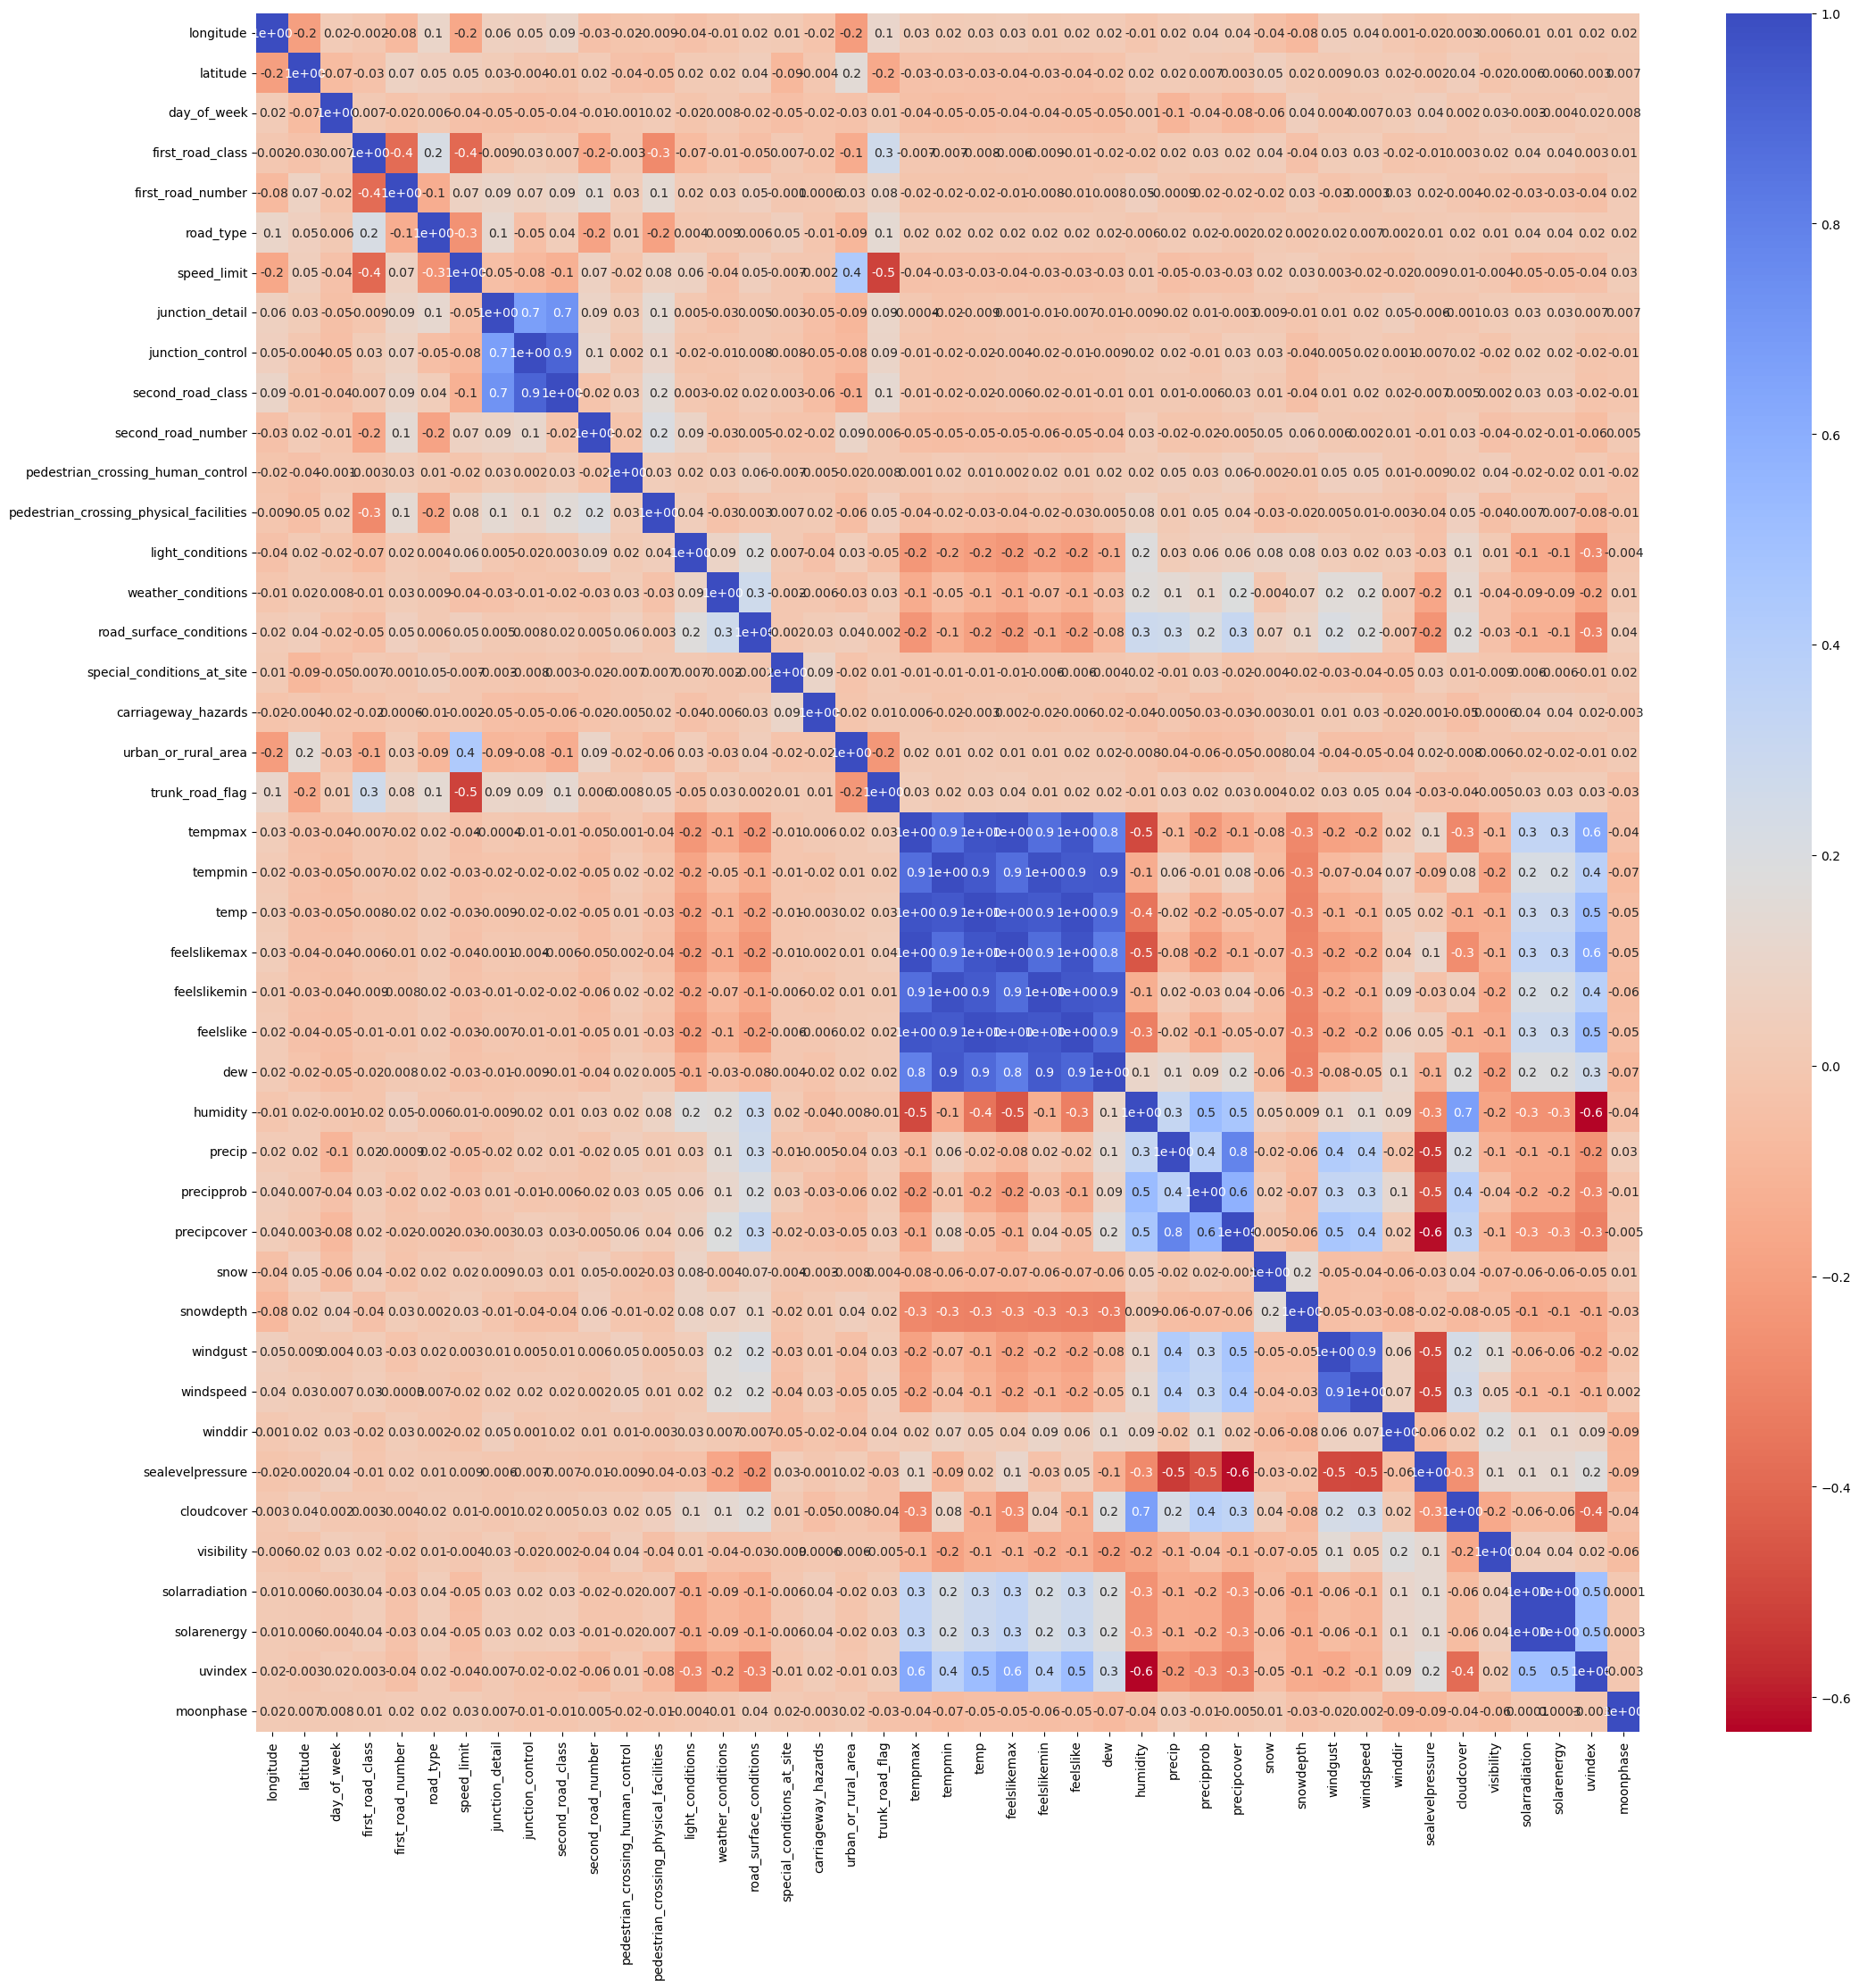

In [108]:
plt.figure(figsize = (25, 25))
sns.heatmap(df2.corr(numeric_only=True), 
            annot = True, 
            fmt = '.1', 
            cmap = 'coolwarm_r', 
           )

plt.show()

Naturally, there is a lot of correlation between anything to do with temperature and indeed across many of the weather data. Perhaps most interestingly there is very little correlation between the weather data and the collision report but I thikn this makes sense because all of the data refers to a crash and never to a non-crash. What could be most interesting is whether weather will have an influence of a number of crashes in a day. For now, I will explore the current data set but afterwards I'll create a dataframe that links weather to the number of crashes. This in turn may lose police information as each crash will have different junction types and road types, for example.

### EDA of current data set

<Axes: xlabel='day_of_week', ylabel='count'>

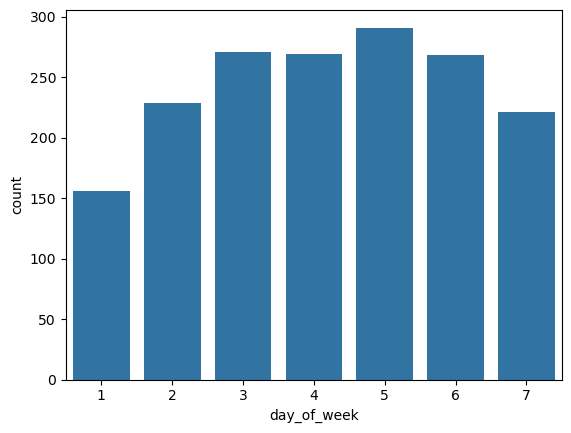

In [111]:
sns.countplot(data = df2, x = 'day_of_week')

Here, Sunday is the first day of the week so the graph shows that most crashes occur on a Thursday and least on a Sunday.

In [114]:
discrete_heads = [ 'first_road_class', #biased by road structure of Bristol?
                  # 'first_road_number', #too many categories
                  'road_type',       #biased by road structure of Bristol?
                  'speed_limit',     #biased by road structure of Bristol?
                  'junction_detail', 
                  # 'junction_control',  #not always relevant
                  # 'second_road_class',   #not always relevant
                  # 'second_road_number',  #too many categories
                  # 'pedestrian_crossing_human_control', #not always relevant
                  # 'pedestrian_crossing_physical_facilities',  #not always relevant
                  'light_conditions',
                  'weather_conditions', 
                  'road_surface_conditions',
                  # 'special_conditions_at_site', # little to learn/clean the data to remove special conditions?
                  # 'carriageway_hazards', # little to learn
                  # 'urban_or_rural_area', #biased by road structure of Bristol? little to learn
                  # 'trunk_road_flag', #biased by road structure of Bristol? little to learn
                  'preciptype', 
                  # 'uvindex', #likely misleading and data quite inconclusive anyway
                  'conditions', 
                  'icon']

In [116]:
df2[discrete_heads].to_csv('police_data.csv')

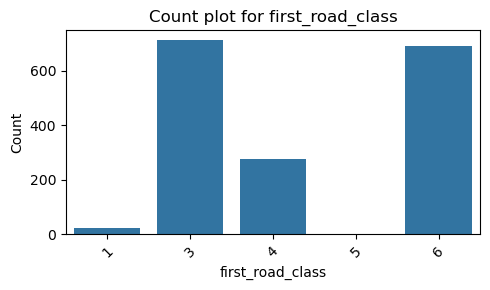

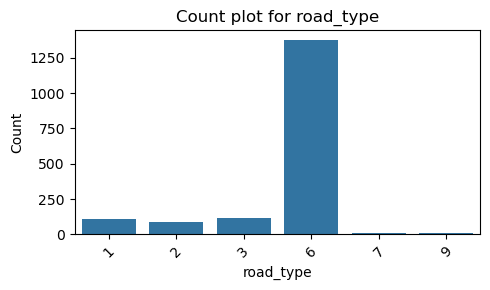

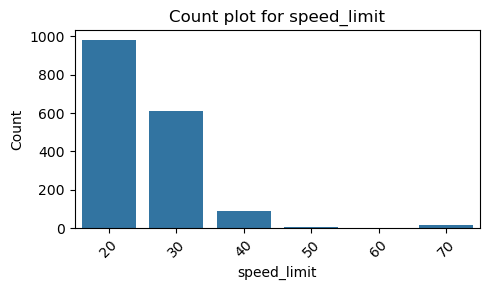

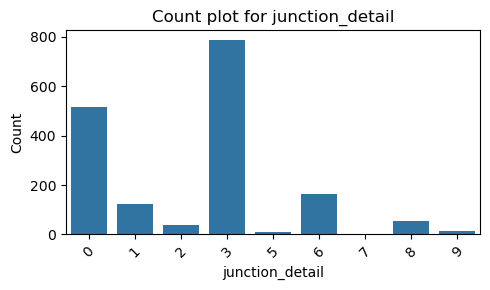

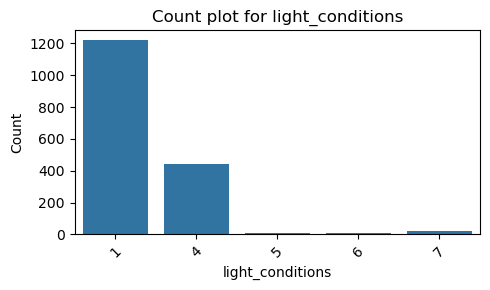

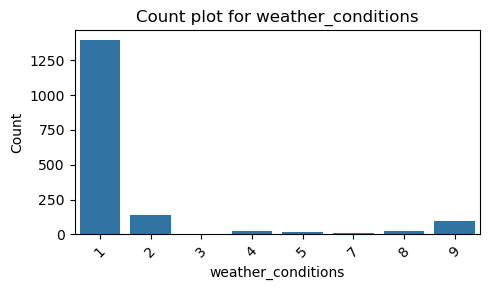

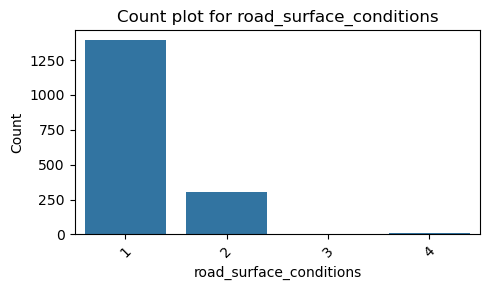

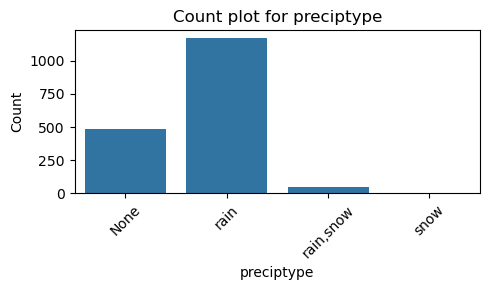

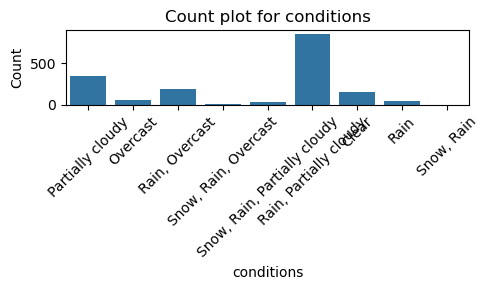

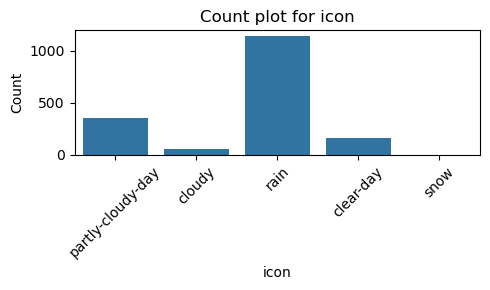

In [118]:
for heading in discrete_heads:
    plt.figure(figsize=(5, 3))  # Create a new figure for each plot
    sns.countplot(data=df2, x=heading)
    plt.title(f'Count plot for {heading}')
    plt.xlabel(heading)
    plt.ylabel('Count')
    plt.xticks(rotation=45)  # Optional: Rotate x-tick labels if they are long
    plt.tight_layout()
    plt.show()

In [119]:
# sns.countplot(data = df2, x = 'weather_conditions')

In [120]:
# sns.countplot(data = df2, x = 'icon')

## Creation of daily crash DF

In [125]:
daily_crash = df2.groupby('date')[['day_of_week']].count()

In [126]:
daily_crash.rename(columns={'day_of_week': 'total crashes'}, inplace=True)

In [127]:
daily_crash

,total crashes
date,
2021-01-03,1
2021-01-04,3
2021-01-05,3
2021-01-06,2
2021-01-07,2
...,...
2022-12-20,1
2022-12-21,2
2022-12-22,4


In [131]:
full_range = pd.date_range("2021-01-01", periods=730, freq="D")

full_range

DatetimeIndex(['2021-01-01', '2021-01-02', '2021-01-03', '2021-01-04',
               '2021-01-05', '2021-01-06', '2021-01-07', '2021-01-08',
               '2021-01-09', '2021-01-10',
               ...
               '2022-12-22', '2022-12-23', '2022-12-24', '2022-12-25',
               '2022-12-26', '2022-12-27', '2022-12-28', '2022-12-29',
               '2022-12-30', '2022-12-31'],
              dtype='datetime64[ns]', length=730, freq='D')

In [132]:
complete_df = pd.DataFrame(full_range, columns=['Date'])
complete_df.set_index('Date', inplace=True)
complete_df.head()

""
Date
2021-01-01
2021-01-02
2021-01-03
2021-01-04
2021-01-05


In [133]:
daily_crashes = complete_df.join(daily_crash, how='left')
daily_crashes.head()

,total crashes
Date,
2021-01-01,NaN
2021-01-02,NaN
2021-01-03,1.0
2021-01-04,3.0
2021-01-05,3.0


In [134]:
daily_crashes['total crashes'] = daily_crashes['total crashes'].fillna(0)

In [135]:
daily_crashes.head()

,total crashes
Date,
2021-01-01,0.0
2021-01-02,0.0
2021-01-03,1.0
2021-01-04,3.0
2021-01-05,3.0


### Daily Crashes analysis (and attaching weather info)

In [143]:
daily_crashes.describe()

,total crashes
count,730.000000
mean,2.335616
std,1.731961
min,0.000000
25%,1.000000
50%,2.000000
75%,3.000000
max,9.000000


<Axes: xlabel='total crashes', ylabel='count'>

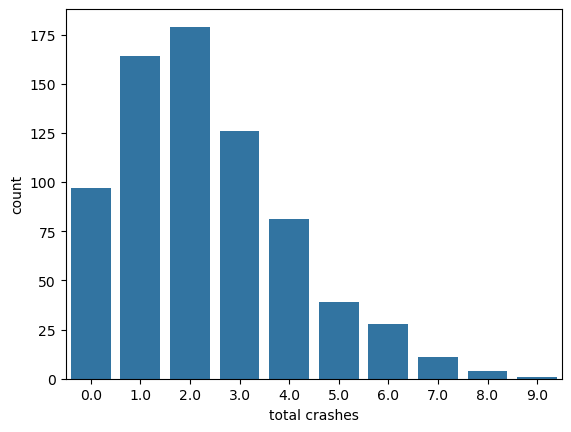

In [145]:
sns.countplot(data = daily_crashes, x = 'total crashes')

In [149]:
df2.columns

Index(['accident_index', 'longitude', 'latitude', 'date', 'day_of_week',
       'time', 'first_road_class', 'first_road_number', 'road_type',
       'speed_limit', 'junction_detail', 'junction_control',
       'second_road_class', 'second_road_number',
       'pedestrian_crossing_human_control',
       'pedestrian_crossing_physical_facilities', 'light_conditions',
       'weather_conditions', 'road_surface_conditions',
       'special_conditions_at_site', 'carriageway_hazards',
       'urban_or_rural_area', 'trunk_road_flag', 'tempmax', 'tempmin', 'temp',
       'feelslikemax', 'feelslikemin', 'feelslike', 'dew', 'humidity',
       'precip', 'precipprob', 'precipcover', 'preciptype', 'snow',
       'snowdepth', 'windgust', 'windspeed', 'winddir', 'sealevelpressure',
       'cloudcover', 'visibility', 'solarradiation', 'solarenergy', 'uvindex',
       'sunrise', 'sunset', 'moonphase', 'conditions', 'description', 'icon'],
      dtype='object')

In [151]:
indep_weather = ['date', 'day_of_week',
        'tempmax', 'tempmin', 'temp',
       'feelslikemax', 'feelslikemin', 'feelslike', 'dew', 'humidity',
       'precip', 'precipprob', 'precipcover', 'preciptype', 'snow',
       'snowdepth', 'windgust', 'windspeed', 'winddir', 'sealevelpressure',
       'cloudcover', 'visibility', 'solarradiation', 'solarenergy', 'uvindex',
       'sunrise', 'sunset', 'moonphase', 'conditions', 'description', 'icon']

In [153]:
df3 = df2[indep_weather]

In [155]:
daily_crashes = daily_crashes.reset_index()

In [157]:
daily_crashes.rename(columns = {'Date':'date'}, inplace = True)

In [158]:
daily_crashes.head()

,date,total crashes
0,2021-01-01,0.0
1,2021-01-02,0.0
2,2021-01-03,1.0
3,2021-01-04,3.0
4,2021-01-05,3.0


In [161]:
dcw = pd.merge(df3,daily_crashes,  on = 'date', how='left') #daily crash weather

In [163]:
crash_weat = pd.merge(daily_crashes,weather,  on = 'date', how='left') #daily crash weather

In [169]:
crash_weat.head(1)

,date,total crashes,tempmax,tempmin,temp,feelslikemax,feelslikemin,feelslike,dew,humidity,precip,precipprob,precipcover,preciptype,snow,snowdepth,windgust,windspeed,winddir,sealevelpressure,cloudcover,visibility,solarradiation,solarenergy,uvindex,sunrise,sunset,moonphase,conditions,description,icon,day_of_week
0,2021-01-01,0.0,3.0,-1.3,1.1,0.0,-3.2,-1.2,0.3,94.6,0.326,100,8.33,"rain,snow",0.0,0.0,26.3,14.5,348.0,1012.0,74.3,10.3,314.2,27.2,1,2021-01-01T08:15:50,2021-01-01T16:12:30,0.58,"Snow, Rain, Partially cloudy",Partly cloudy throughout the day with rain or ...,rain,6


In [171]:
crash_weat['day_of_week'] = crash_weat['date'].dt.dayofweek+2

In [173]:
crash_weat.head(1)

,date,total crashes,tempmax,tempmin,temp,feelslikemax,feelslikemin,feelslike,dew,humidity,precip,precipprob,precipcover,preciptype,snow,snowdepth,windgust,windspeed,winddir,sealevelpressure,cloudcover,visibility,solarradiation,solarenergy,uvindex,sunrise,sunset,moonphase,conditions,description,icon,day_of_week
0,2021-01-01,0.0,3.0,-1.3,1.1,0.0,-3.2,-1.2,0.3,94.6,0.326,100,8.33,"rain,snow",0.0,0.0,26.3,14.5,348.0,1012.0,74.3,10.3,314.2,27.2,1,2021-01-01T08:15:50,2021-01-01T16:12:30,0.58,"Snow, Rain, Partially cloudy",Partly cloudy throughout the day with rain or ...,rain,6


In [175]:
crash_weat.to_csv('Weather and crashes per day.csv')

In [179]:
dcw.head(1)

,date,day_of_week,tempmax,tempmin,temp,feelslikemax,feelslikemin,feelslike,dew,humidity,precip,precipprob,precipcover,preciptype,snow,snowdepth,windgust,windspeed,winddir,sealevelpressure,cloudcover,visibility,solarradiation,solarenergy,uvindex,sunrise,sunset,moonphase,conditions,description,icon,total crashes
0,2021-01-04,2,3.3,1.0,2.2,-1.9,-5.0,-3.2,0.7,90.5,0.0,0,0.0,None,0.0,0.0,54.4,31.3,33.6,1020.3,88.8,12.4,363.7,31.6,1,2021-01-04T08:15:15,2021-01-04T16:15:53,0.69,Partially cloudy,Partly cloudy throughout the day.,partly-cloudy-day,3.0


In [185]:
dcw.sort_values(by ='date', ascending =True).head(2)

,date,day_of_week,tempmax,tempmin,temp,feelslikemax,feelslikemin,feelslike,dew,humidity,precip,precipprob,precipcover,preciptype,snow,snowdepth,windgust,windspeed,winddir,sealevelpressure,cloudcover,visibility,solarradiation,solarenergy,uvindex,sunrise,sunset,moonphase,conditions,description,icon,total crashes
70,2021-01-03,1,3.1,0.0,1.7,0.0,-4.5,-2.7,1.4,97.6,0.286,100,12.5,"rain,snow",0.0,0.0,37.8,26.7,30.9,1017.6,95.8,8.2,298.3,25.8,1,2021-01-03T08:15:30,2021-01-03T16:14:43,0.65,"Snow, Rain, Overcast",Cloudy skies throughout the day with a chance ...,rain,1.0
0,2021-01-04,2,3.3,1.0,2.2,-1.9,-5.0,-3.2,0.7,90.5,0.000,0,0.0,None,0.0,0.0,54.4,31.3,33.6,1020.3,88.8,12.4,363.7,31.6,1,2021-01-04T08:15:15,2021-01-04T16:15:53,0.69,Partially cloudy,Partly cloudy throughout the day.,partly-cloudy-day,3.0


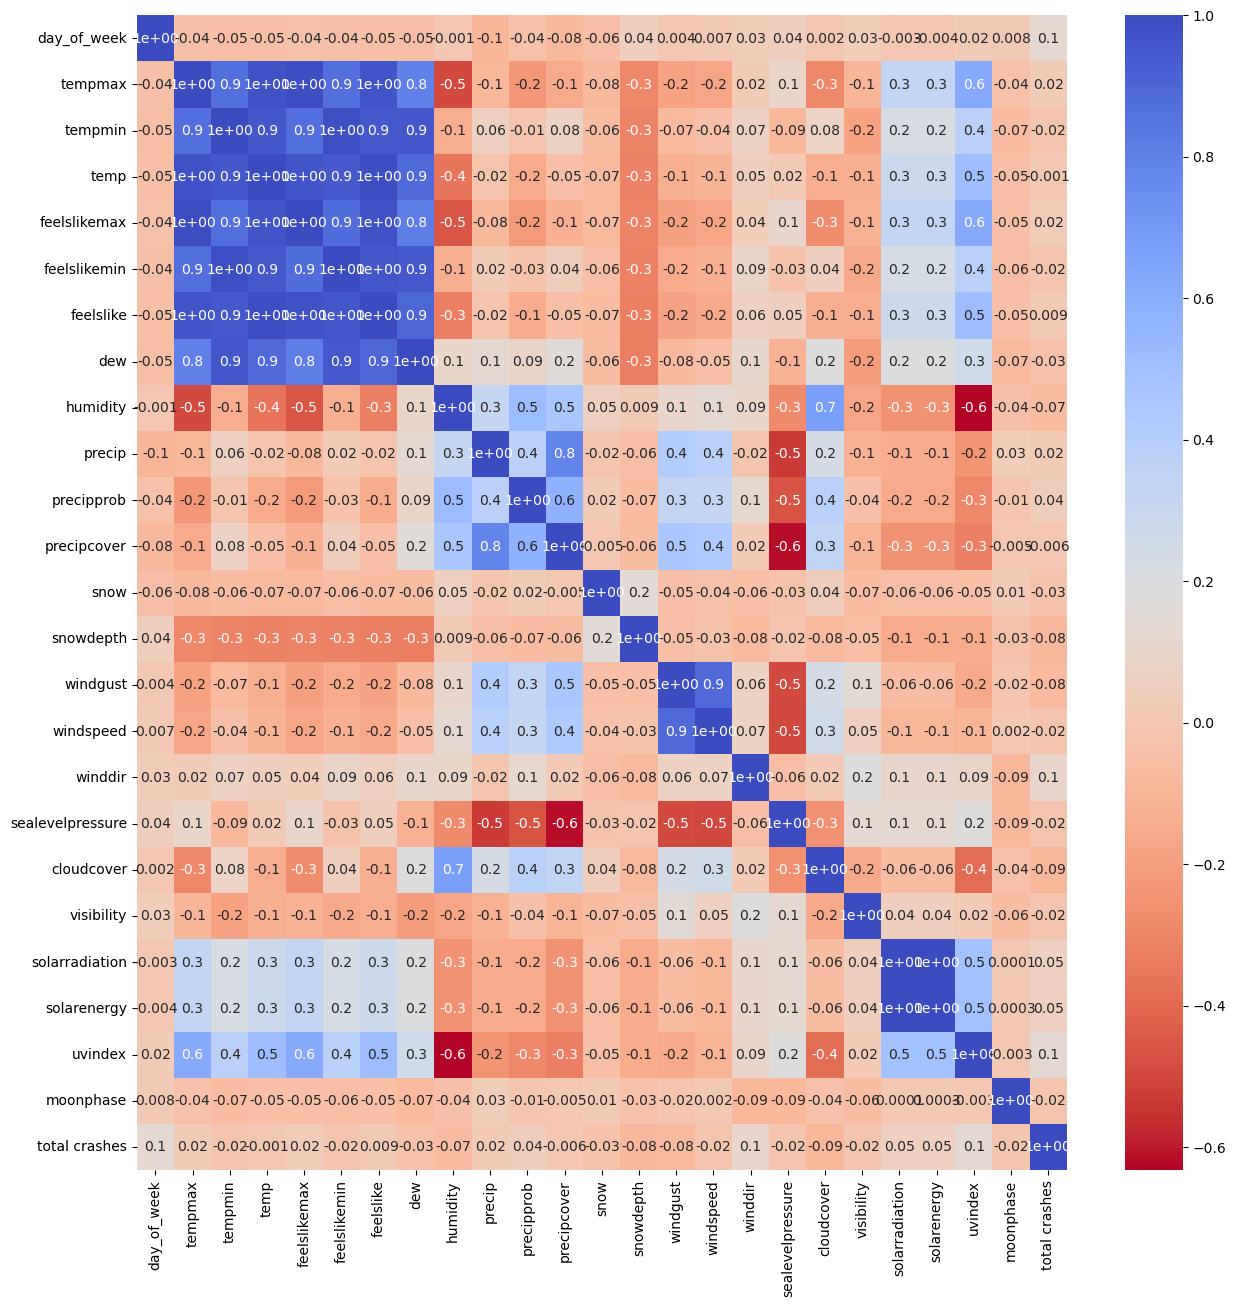

In [187]:
plt.figure(figsize = (15, 15))
sns.heatmap(dcw.corr(numeric_only=True), 
            annot = True, 
            fmt = '.1', 
            cmap = 'coolwarm_r', 
           )

plt.show()

### Is there a pattern with time?

In [189]:
daily_crashes.head()

,date,total crashes
0,2021-01-01,0.0
1,2021-01-02,0.0
2,2021-01-03,1.0
3,2021-01-04,3.0
4,2021-01-05,3.0


In [191]:
daily_crashes.set_index('date', inplace=True)

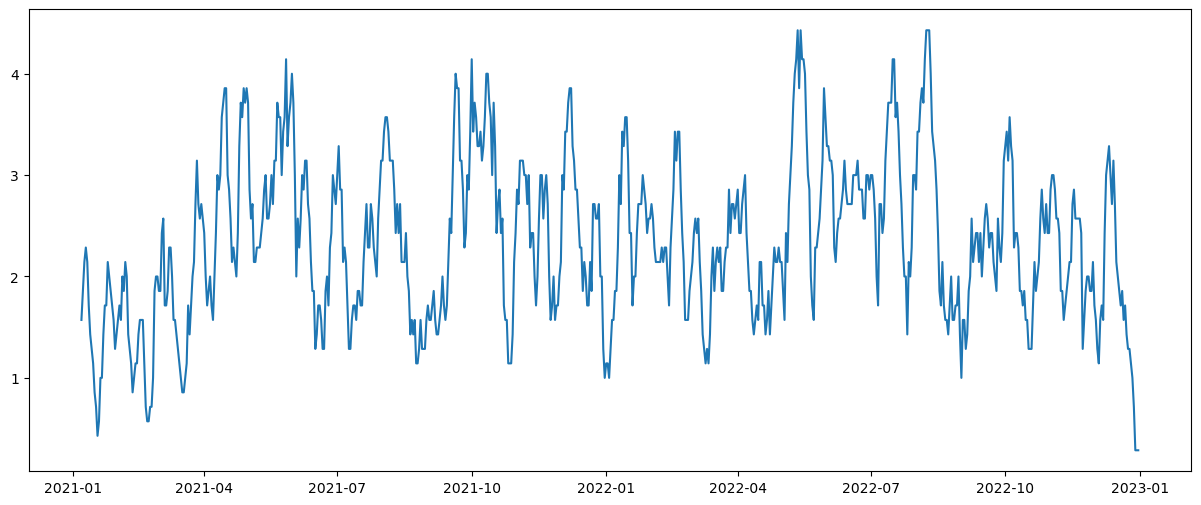

In [192]:
plt.figure(figsize=(15,6))
# plt.plot(daily_crashes['total crashes']) #blue
# plt.plot(daily_crashes['total crashes'].rolling(2).mean()) #orange
plt.plot(daily_crashes['total crashes'].rolling(7).mean())

## Crude modelling

### Train test splitting

In [195]:
crash_weat.columns

Index(['date', 'total crashes', 'tempmax', 'tempmin', 'temp', 'feelslikemax',
       'feelslikemin', 'feelslike', 'dew', 'humidity', 'precip', 'precipprob',
       'precipcover', 'preciptype', 'snow', 'snowdepth', 'windgust',
       'windspeed', 'winddir', 'sealevelpressure', 'cloudcover', 'visibility',
       'solarradiation', 'solarenergy', 'uvindex', 'sunrise', 'sunset',
       'moonphase', 'conditions', 'description', 'icon', 'day_of_week'],
      dtype='object')

In [197]:
# dcw.columns

In [199]:
feature_cols = [
    'day_of_week', 
                'temp', 'dew', 'humidity', 'precip', 'precipprob',
        'snow', 'snowdepth', 'windspeed', 'winddir', 'sealevelpressure', 'cloudcover', 'visibility',
       'solarradiation', 'uvindex', 'moonphase']

In [249]:
# Features
X = crash_weat_ohe[feature_cols]
# Target (the 'total crashes' column)
y = crash_weat_ohe['total crashes']

In [251]:
#Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

### Using a DT

In [254]:
grid = GridSearchCV(estimator = DT(),
                    param_grid = {'max_depth': [8,10,12],
                                  'min_samples_split': [5, 10],
                                  # 'min_samples_leaf': [3, 4, 5],
                                  'max_features':[5,6,7,8]},
                    cv = 5,
                    refit = True,
                    verbose = 1,
                    scoring = 'accuracy')


grid.fit(X_train, y_train)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


C:\Users\admin\anaconda3\Lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


GridSearchCV(cv=5, estimator=DecisionTreeClassifier(),
             param_grid={'max_depth': [8, 10, 12], 'max_features': [5, 6, 7, 8],
                         'min_samples_split': [5, 10]},
             scoring='accuracy', verbose=1)

In [255]:
grid.best_score_

0.23116710875331564

In [207]:
best_dt = grid.best_estimator_
best_dt

DecisionTreeClassifier(max_depth=8, max_features=5, min_samples_split=10)

In [211]:
results = X_train.copy()
y_pred = best_dt.predict(results)
results['y_pred'] = y_pred
results['y_real'] = y

In [213]:
results.head()

,day_of_week,temp,dew,humidity,precip,precipprob,snow,snowdepth,windspeed,winddir,sealevelpressure,cloudcover,visibility,solarradiation,uvindex,moonphase,y_pred,y_real
247,8,16.7,14.7,88.7,0.000,0,0.0,0.0,15.3,79.7,1020.2,48.3,5.9,426.4,6,0.95,1.0,2.0
335,5,2.2,-1.8,75.3,0.123,100,0.0,0.0,21.0,300.0,1013.0,36.6,14.5,159.5,2,0.94,1.0,9.0
702,8,2.9,1.4,89.8,0.034,100,0.0,0.0,27.2,56.5,1016.4,96.4,8.6,6.8,0,0.37,0.0,1.0
440,5,7.0,4.3,83.9,0.168,100,0.0,0.0,24.9,238.9,1031.9,43.9,21.6,136.5,6,0.47,2.0,4.0
136,2,10.6,8.3,86.4,1.224,100,0.0,0.0,30.1,265.6,1005.7,58.5,12.2,496.3,7,0.19,2.0,4.0


This crude result gives me less confidence that a reasonable model can be abtained. I will now look to engineer some of the features so that more can be utilised in the model.

## Feature engineering

### Engineering of police data

In [ ]:
# df2.columns


In [ ]:
# daily_crash2 = df2.groupby('date').agg({'first_road_class':pd.Series.mode,
#                          'first_road_number':pd.Series.mode, 
#                          'road_type':pd.Series.mode,
#                          'speed_limit':'mean', 
#                          'junction_detail':pd.Series.mode, 
#                          'junction_control':pd.Series.mode,
#                          'second_road_class':pd.Series.mode, 
#                          'second_road_number':pd.Series.mode,
#                          'pedestrian_crossing_human_control':pd.Series.mode,
#                          'pedestrian_crossing_physical_facilities':pd.Series.mode,
#                          'light_conditions':pd.Series.mode,
#                          'weather_conditions':pd.Series.mode, 
#                          'road_surface_conditions':pd.Series.mode,
#                          'special_conditions_at_site':pd.Series.mode, 
#                          'carriageway_hazards':pd.Series.mode,
#                          'urban_or_rural_area':pd.Series.mode,
#                          'trunk_road_flag':pd.Series.mode,
#                          'day_of_week':'size'})

In [ ]:
# daily_crash2.rename(columns={'day_of_week': 'total crashes'}, inplace=True)

In [ ]:
# daily_crashes2 = complete_df.join(daily_crash2, how='left')
# daily_crashes2.head()

In [ ]:
# daily_crashes2['total crashes'] = daily_crashes2['total crashes'].fillna(0)

In [ ]:
# daily_crashes2 = daily_crashes2.reset_index()

In [ ]:
# daily_crashes2.head()

In [ ]:
# daily_crashes2['junction_control'][3]

In [ ]:
# def arraytonum(item):
#     if isinstance(item, np.ndarray):
#         return  -2
#     else:
#         return item

In [ ]:
# daily_crashes2 = daily_crashes2.fillna(-3)

In [ ]:
# daily_crashes2.columns

In [ ]:
# for heading in daily_crashes2.columns:
#     daily_crashes2[heading] = daily_crashes2[heading].apply(arraytonum)

In [ ]:
# daily_crashes2.head()

In [ ]:
# daily_crashes2.rename(columns = {'Date':'date'}, inplace = True)

In [ ]:
# dcw2 = pd.merge(df3, daily_crashes2, on = 'date', how='left') #daily crash weather2

In [ ]:
# dcw2.shape

### Engineering crash_weat

In [220]:
crash_weat.head(2)

,date,total crashes,tempmax,tempmin,temp,feelslikemax,feelslikemin,feelslike,dew,humidity,precip,precipprob,precipcover,preciptype,snow,snowdepth,windgust,windspeed,winddir,sealevelpressure,cloudcover,visibility,solarradiation,solarenergy,uvindex,sunrise,sunset,moonphase,conditions,description,icon,day_of_week
0,2021-01-01,0.0,3.0,-1.3,1.1,0.0,-3.2,-1.2,0.3,94.6,0.326,100,8.33,"rain,snow",0.0,0.0,26.3,14.5,348.0,1012.0,74.3,10.3,314.2,27.2,1,2021-01-01T08:15:50,2021-01-01T16:12:30,0.58,"Snow, Rain, Partially cloudy",Partly cloudy throughout the day with rain or ...,rain,6
1,2021-01-02,0.0,3.0,-1.0,1.1,1.0,-5.4,-1.9,-0.1,91.8,0.681,100,12.50,"rain,snow",0.0,0.0,24.8,21.4,337.1,1016.4,64.6,11.2,146.0,12.6,2,2021-01-02T08:15:41,2021-01-02T16:13:35,0.62,"Snow, Rain, Partially cloudy",Partly cloudy throughout the day with rain or ...,rain,7


In [268]:
crash_weat_ohe = pd.get_dummies(crash_weat, columns = ['preciptype','conditions','icon'], prefix = ['preciptype','conditions','icon'],  drop_first = True,dtype=int)

In [270]:
crash_weat_ohe.head(2)

,date,total crashes,tempmax,tempmin,temp,feelslikemax,feelslikemin,feelslike,dew,humidity,precip,precipprob,precipcover,snow,snowdepth,windgust,windspeed,winddir,sealevelpressure,cloudcover,visibility,solarradiation,solarenergy,uvindex,sunrise,sunset,moonphase,description,day_of_week,"preciptype_rain,snow",preciptype_snow,conditions_Overcast,conditions_Partially cloudy,conditions_Rain,"conditions_Rain, Overcast","conditions_Rain, Partially cloudy","conditions_Snow, Rain","conditions_Snow, Rain, Overcast","conditions_Snow, Rain, Partially cloudy",icon_cloudy,icon_partly-cloudy-day,icon_rain,icon_snow
0,2021-01-01,0.0,3.0,-1.3,1.1,0.0,-3.2,-1.2,0.3,94.6,0.326,100,8.33,0.0,0.0,26.3,14.5,348.0,1012.0,74.3,10.3,314.2,27.2,1,2021-01-01T08:15:50,2021-01-01T16:12:30,0.58,Partly cloudy throughout the day with rain or ...,6,1,0,0,0,0,0,0,0,0,1,0,0,1,0
1,2021-01-02,0.0,3.0,-1.0,1.1,1.0,-5.4,-1.9,-0.1,91.8,0.681,100,12.50,0.0,0.0,24.8,21.4,337.1,1016.4,64.6,11.2,146.0,12.6,2,2021-01-02T08:15:41,2021-01-02T16:13:35,0.62,Partly cloudy throughout the day with rain or ...,7,1,0,0,0,0,0,0,0,0,1,0,0,1,0


## Crude modelling 2

### Train test splitting

In [272]:
crash_weat_ohe.columns

Index(['date', 'total crashes', 'tempmax', 'tempmin', 'temp', 'feelslikemax',
       'feelslikemin', 'feelslike', 'dew', 'humidity', 'precip', 'precipprob',
       'precipcover', 'snow', 'snowdepth', 'windgust', 'windspeed', 'winddir',
       'sealevelpressure', 'cloudcover', 'visibility', 'solarradiation',
       'solarenergy', 'uvindex', 'sunrise', 'sunset', 'moonphase',
       'description', 'day_of_week', 'preciptype_rain,snow', 'preciptype_snow',
       'conditions_Overcast', 'conditions_Partially cloudy', 'conditions_Rain',
       'conditions_Rain, Overcast', 'conditions_Rain, Partially cloudy',
       'conditions_Snow, Rain', 'conditions_Snow, Rain, Overcast',
       'conditions_Snow, Rain, Partially cloudy', 'icon_cloudy',
       'icon_partly-cloudy-day', 'icon_rain', 'icon_snow'],
      dtype='object')

In [274]:
feature_cols = ['day_of_week', 'temp', 'dew', 'humidity', 'precip', 'precipprob',
        'snow', 'snowdepth', 'windspeed', 'winddir', 'sealevelpressure', 'cloudcover', 'visibility',
       'solarradiation', 'uvindex', 'moonphase', 'preciptype_rain,snow', 'preciptype_snow',
       'conditions_Overcast', 'conditions_Partially cloudy', 'conditions_Rain',
       'conditions_Rain, Overcast', 'conditions_Rain, Partially cloudy',
       'conditions_Snow, Rain', 'conditions_Snow, Rain, Overcast',
       'conditions_Snow, Rain, Partially cloudy',
        'icon_cloudy',
       'icon_partly-cloudy-day', 'icon_rain', 'icon_snow']

In [ ]:
# feature_cols2 =['day_of_week', 'temp', 'dew', 'humidity', 'precip', 'precipprob',
#                 'snow', 'snowdepth', 'windgust', 'winddir', 'sealevelpressure', 'cloudcover', 'visibility',
#        'solarradiation', 'uvindex', 'moonphase', 'first_road_class',
#        'first_road_number', 'road_type', 'speed_limit', 'junction_detail',
#        'junction_control', 'second_road_class', 'second_road_number',
#        'pedestrian_crossing_human_control',
#        'pedestrian_crossing_physical_facilities', 'light_conditions',
#        'weather_conditions', 'road_surface_conditions',
#        'special_conditions_at_site', 'carriageway_hazards',
#        'urban_or_rural_area', 'trunk_road_flag', 'total crashes']

In [276]:
# Features
X = crash_weat_ohe[feature_cols]
# Target (the 'total crashes' column)
y = crash_weat_ohe['total crashes']

In [278]:
#Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

### Using a DT

In [281]:
grid = GridSearchCV(estimator = DT(),
                    param_grid = {'max_depth': [10,12],
                                  'min_samples_split': [5, 10],
                                  # 'min_samples_leaf': [3, 4, 5],
                                  'max_features':[5,7,9,14,18]},
                    cv = 5,
                    refit = True,
                    verbose = 1,
                    scoring = 'accuracy')


grid.fit(X_train, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


C:\Users\admin\anaconda3\Lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


GridSearchCV(cv=5, estimator=DecisionTreeClassifier(),
             param_grid={'max_depth': [10, 12],
                         'max_features': [5, 7, 9, 14, 18],
                         'min_samples_split': [5, 10]},
             scoring='accuracy', verbose=1)

In [283]:
grid.best_score_

0.224314765694076

In [285]:
best_dt = grid.best_estimator_
best_dt

DecisionTreeClassifier(max_depth=12, max_features=9, min_samples_split=5)

In [287]:
results = X_train.copy()
y_pred = best_dt.predict(results)
results['y_pred'] = y_pred
results['y_real'] = y

In [289]:
results.head(2)

,day_of_week,temp,dew,humidity,precip,precipprob,snow,snowdepth,windspeed,winddir,sealevelpressure,cloudcover,visibility,solarradiation,uvindex,moonphase,"preciptype_rain,snow",preciptype_snow,conditions_Overcast,conditions_Partially cloudy,conditions_Rain,"conditions_Rain, Overcast","conditions_Rain, Partially cloudy","conditions_Snow, Rain","conditions_Snow, Rain, Overcast","conditions_Snow, Rain, Partially cloudy",icon_cloudy,icon_partly-cloudy-day,icon_rain,icon_snow,y_pred,y_real
247,8,16.7,14.7,88.7,0.000,0,0.0,0.0,15.3,79.7,1020.2,48.3,5.9,426.4,6,0.95,0,0,0,1,0,0,0,0,0,0,0,1,0,0,2.0,2.0
335,5,2.2,-1.8,75.3,0.123,100,0.0,0.0,21.0,300.0,1013.0,36.6,14.5,159.5,2,0.94,0,0,0,0,0,0,1,0,0,0,0,0,1,0,2.0,9.0


In [291]:
test_results = X_test.copy()
y_pred_test=best_dt.predict(X_test)
test_results['y_pred'] = y_pred_test
test_results['y_real'] = y_test

In [293]:
test_results.head()

,day_of_week,temp,dew,humidity,precip,precipprob,snow,snowdepth,windspeed,winddir,sealevelpressure,cloudcover,visibility,solarradiation,uvindex,moonphase,"preciptype_rain,snow",preciptype_snow,conditions_Overcast,conditions_Partially cloudy,conditions_Rain,"conditions_Rain, Overcast","conditions_Rain, Partially cloudy","conditions_Snow, Rain","conditions_Snow, Rain, Overcast","conditions_Snow, Rain, Partially cloudy",icon_cloudy,icon_partly-cloudy-day,icon_rain,icon_snow,y_pred,y_real
468,5,11.5,8.4,82.2,0.061,100,0.0,0.0,12.6,191.7,1021.6,75.3,11.1,116.5,4,0.42,0,0,0,0,0,0,1,0,0,0,0,0,1,0,3.0,3.0
148,7,15.7,9.9,70.6,0.000,0,0.0,0.0,20.9,63.6,1026.0,70.6,12.8,496.4,8,0.60,0,0,0,1,0,0,0,0,0,0,0,1,0,0,2.0,3.0
302,7,10.1,7.9,86.5,5.662,100,0.0,0.0,24.1,199.1,995.1,51.6,12.7,377.6,4,0.82,0,0,0,0,0,0,1,0,0,0,0,0,1,0,4.0,5.0
355,4,2.4,1.1,91.3,0.382,100,0.0,0.0,27.9,107.2,1016.3,60.7,9.1,320.9,1,0.61,0,0,0,0,0,0,1,0,0,0,0,0,1,0,6.0,0.0
515,3,10.9,7.0,77.9,1.155,100,0.0,0.0,31.4,252.0,1012.4,57.7,12.1,223.6,9,0.03,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1.0,6.0


In [735]:
def apr(y_pred, y_real, average='weighted', zero_division=0):
    
    accuracy = metrics.accuracy_score(y_real, y_pred)
    precision = metrics.precision_score(y_real, y_pred, average=average, zero_division=zero_division)
    recall = metrics.recall_score(y_real, y_pred, average=average, zero_division=zero_division)
    f1 = metrics.f1_score(y_real, y_pred, average=average, zero_division=zero_division)
    
    print(f"Accuracy:{accuracy}")
    print(f"Precision:{precision}")
    print(f"Recall:{recall}")
    print(f"F1:{f1}")
    # return accuracy , precision, recall, f1

In [737]:
apr(y_pred_test, y_test)

Accuracy:0.4726027397260274
Precision:0.43984457323498416
Recall:0.4726027397260274
F1:0.3707847470629472


In [739]:
apr(y_pred, y_train)

Accuracy:0.4863013698630137
Precision:0.4355240269623831
Recall:0.4863013698630137
F1:0.39240319067440005


### Using a RF

In [302]:
# (n_estimators=100,
#  criterion='gini', 
#  max_depth=None,
#  min_samples_split=2, 
#  min_samples_leaf=1, 
#  min_weight_fraction_leaf=0.0, 
#  max_features='sqrt', 
#  max_leaf_nodes=None, 
#  min_impurity_decrease=0.0, 
#  bootstrap=True, 
#  oob_score=False, 
#  n_jobs=None, 
#  random_state=None, 
#  verbose=0, 
#  warm_start=False, 
#  class_weight=None, 
#  ccp_alpha=0.0, 
#  max_samples=None, 
#  monotonic_cst=None)


In [304]:
rf = RF() # Random Forests

#Selecting parameters to vary
rf_params = {
    'n_estimators': [50, 100, 200], 
    'max_depth': [6, 9, 12],
    'min_samples_split': [2, 4, 6, 8, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

# Create a grid search object
gs = GridSearchCV(rf, param_grid=rf_params, cv=5, verbose = 1) 

# Fit grid search on the training set
gs.fit(X_train, y_train)

Fitting 5 folds for each of 270 candidates, totalling 1350 fits


C:\Users\admin\anaconda3\Lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'bootstrap': [True, False], 'max_depth': [6, 9, 12],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 4, 6, 8, 10],
                         'n_estimators': [50, 100, 200]},
             verbose=1)

In [305]:
gs.best_score_

0.2688623636899499

In [308]:
best_rf = gs.best_estimator_
best_rf

RandomForestClassifier(bootstrap=False, max_depth=6, n_estimators=50)

In [311]:
results = X_train.copy()
y_pred = best_rf.predict(results)
results['y_pred'] = y_pred
results['y_real'] = y

In [312]:
results.head(2)

,day_of_week,temp,dew,humidity,precip,precipprob,snow,snowdepth,windspeed,winddir,sealevelpressure,cloudcover,visibility,solarradiation,uvindex,moonphase,"preciptype_rain,snow",preciptype_snow,conditions_Overcast,conditions_Partially cloudy,conditions_Rain,"conditions_Rain, Overcast","conditions_Rain, Partially cloudy","conditions_Snow, Rain","conditions_Snow, Rain, Overcast","conditions_Snow, Rain, Partially cloudy",icon_cloudy,icon_partly-cloudy-day,icon_rain,icon_snow,y_pred,y_real
247,8,16.7,14.7,88.7,0.000,0,0.0,0.0,15.3,79.7,1020.2,48.3,5.9,426.4,6,0.95,0,0,0,1,0,0,0,0,0,0,0,1,0,0,2.0,2.0
335,5,2.2,-1.8,75.3,0.123,100,0.0,0.0,21.0,300.0,1013.0,36.6,14.5,159.5,2,0.94,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1.0,9.0


In [313]:
test_results = X_test.copy()
y_pred_test=best_rf.predict(X_test)
test_results['y_pred'] = y_pred_test
test_results['y_real'] = y_test

In [315]:
test_results.head()

,day_of_week,temp,dew,humidity,precip,precipprob,snow,snowdepth,windspeed,winddir,sealevelpressure,cloudcover,visibility,solarradiation,uvindex,moonphase,"preciptype_rain,snow",preciptype_snow,conditions_Overcast,conditions_Partially cloudy,conditions_Rain,"conditions_Rain, Overcast","conditions_Rain, Partially cloudy","conditions_Snow, Rain","conditions_Snow, Rain, Overcast","conditions_Snow, Rain, Partially cloudy",icon_cloudy,icon_partly-cloudy-day,icon_rain,icon_snow,y_pred,y_real
468,5,11.5,8.4,82.2,0.061,100,0.0,0.0,12.6,191.7,1021.6,75.3,11.1,116.5,4,0.42,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1.0,3.0
148,7,15.7,9.9,70.6,0.000,0,0.0,0.0,20.9,63.6,1026.0,70.6,12.8,496.4,8,0.60,0,0,0,1,0,0,0,0,0,0,0,1,0,0,2.0,3.0
302,7,10.1,7.9,86.5,5.662,100,0.0,0.0,24.1,199.1,995.1,51.6,12.7,377.6,4,0.82,0,0,0,0,0,0,1,0,0,0,0,0,1,0,2.0,5.0
355,4,2.4,1.1,91.3,0.382,100,0.0,0.0,27.9,107.2,1016.3,60.7,9.1,320.9,1,0.61,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1.0,0.0
515,3,10.9,7.0,77.9,1.155,100,0.0,0.0,31.4,252.0,1012.4,57.7,12.1,223.6,9,0.03,0,0,0,0,0,0,1,0,0,0,0,0,1,0,3.0,6.0


In [741]:
apr(y_pred_test, y_test)

Accuracy:0.4726027397260274
Precision:0.43984457323498416
Recall:0.4726027397260274
F1:0.3707847470629472


In [743]:
apr(y_pred, y_train)

Accuracy:0.4863013698630137
Precision:0.4355240269623831
Recall:0.4863013698630137
F1:0.39240319067440005


Things to fix: I don't think blaket filling with -2 is a good idea - either the code for unknown mucst be used or the mode so that it is less 'obvious' to the computer.
Also: bucket the categories for classification.

## Using buckets to simplify the model

In [323]:
crash_weat_ohe.head(1)

,date,total crashes,tempmax,tempmin,temp,feelslikemax,feelslikemin,feelslike,dew,humidity,precip,precipprob,precipcover,snow,snowdepth,windgust,windspeed,winddir,sealevelpressure,cloudcover,visibility,solarradiation,solarenergy,uvindex,sunrise,sunset,moonphase,description,day_of_week,"preciptype_rain,snow",preciptype_snow,conditions_Overcast,conditions_Partially cloudy,conditions_Rain,"conditions_Rain, Overcast","conditions_Rain, Partially cloudy","conditions_Snow, Rain","conditions_Snow, Rain, Overcast","conditions_Snow, Rain, Partially cloudy",icon_cloudy,icon_partly-cloudy-day,icon_rain,icon_snow
0,2021-01-01,0.0,3.0,-1.3,1.1,0.0,-3.2,-1.2,0.3,94.6,0.326,100,8.33,0.0,0.0,26.3,14.5,348.0,1012.0,74.3,10.3,314.2,27.2,1,2021-01-01T08:15:50,2021-01-01T16:12:30,0.58,Partly cloudy throughout the day with rain or ...,6,1,0,0,0,0,0,0,0,0,1,0,0,1,0


In [325]:
def bucketer(val):
    if val<=1:
        return 'A'
    elif val <=3:
        return 'B'
    else:
        return 'C'

In [327]:
crash_weat_ohe['bucket'] = crash_weat_ohe['total crashes'].apply(bucketer)

In [329]:
crash_weat_ohe.head(2)

,date,total crashes,tempmax,tempmin,temp,feelslikemax,feelslikemin,feelslike,dew,humidity,precip,precipprob,precipcover,snow,snowdepth,windgust,windspeed,winddir,sealevelpressure,cloudcover,visibility,solarradiation,solarenergy,uvindex,sunrise,sunset,moonphase,description,day_of_week,"preciptype_rain,snow",preciptype_snow,conditions_Overcast,conditions_Partially cloudy,conditions_Rain,"conditions_Rain, Overcast","conditions_Rain, Partially cloudy","conditions_Snow, Rain","conditions_Snow, Rain, Overcast","conditions_Snow, Rain, Partially cloudy",icon_cloudy,icon_partly-cloudy-day,icon_rain,icon_snow,bucket
0,2021-01-01,0.0,3.0,-1.3,1.1,0.0,-3.2,-1.2,0.3,94.6,0.326,100,8.33,0.0,0.0,26.3,14.5,348.0,1012.0,74.3,10.3,314.2,27.2,1,2021-01-01T08:15:50,2021-01-01T16:12:30,0.58,Partly cloudy throughout the day with rain or ...,6,1,0,0,0,0,0,0,0,0,1,0,0,1,0,A
1,2021-01-02,0.0,3.0,-1.0,1.1,1.0,-5.4,-1.9,-0.1,91.8,0.681,100,12.50,0.0,0.0,24.8,21.4,337.1,1016.4,64.6,11.2,146.0,12.6,2,2021-01-02T08:15:41,2021-01-02T16:13:35,0.62,Partly cloudy throughout the day with rain or ...,7,1,0,0,0,0,0,0,0,0,1,0,0,1,0,A


### Using a DT for the buckets

In [684]:
# Features
X = crash_weat_ohe[feature_cols]
# Target (the 'total crashes' column)
y = crash_weat_ohe['bucket']

In [686]:
#Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [335]:
grid = GridSearchCV(estimator = DT(),
                    param_grid = {'max_depth': [4,5,6],
                                  'min_samples_split': [5, 10],
                                  # 'min_samples_leaf': [3, 4, 5],
                                  'max_features':[5,7,9,14,18]},
                    cv = 5,
                    refit = True,
                    verbose = 1,
                    scoring = 'accuracy')


grid.fit(X_train, y_train)

Fitting 5 folds for each of 30 candidates, totalling 150 fits


GridSearchCV(cv=5, estimator=DecisionTreeClassifier(),
             param_grid={'max_depth': [4, 5, 6],
                         'max_features': [5, 7, 9, 14, 18],
                         'min_samples_split': [5, 10]},
             scoring='accuracy', verbose=1)

In [336]:
grid.best_score_

0.43144709696433836

In [339]:
best_dt = grid.best_estimator_
best_dt

DecisionTreeClassifier(max_depth=5, max_features=7, min_samples_split=10)

In [341]:
results = X_train.copy()
y_pred = best_dt.predict(results)
results['y_pred'] = y_pred
results['y_real'] = y

In [343]:
results.head(2)

,day_of_week,temp,dew,humidity,precip,precipprob,snow,snowdepth,windspeed,winddir,sealevelpressure,cloudcover,visibility,solarradiation,uvindex,moonphase,"preciptype_rain,snow",preciptype_snow,conditions_Overcast,conditions_Partially cloudy,conditions_Rain,"conditions_Rain, Overcast","conditions_Rain, Partially cloudy","conditions_Snow, Rain","conditions_Snow, Rain, Overcast","conditions_Snow, Rain, Partially cloudy",icon_cloudy,icon_partly-cloudy-day,icon_rain,icon_snow,y_pred,y_real
247,8,16.7,14.7,88.7,0.000,0,0.0,0.0,15.3,79.7,1020.2,48.3,5.9,426.4,6,0.95,0,0,0,1,0,0,0,0,0,0,0,1,0,0,A,B
335,5,2.2,-1.8,75.3,0.123,100,0.0,0.0,21.0,300.0,1013.0,36.6,14.5,159.5,2,0.94,0,0,0,0,0,0,1,0,0,0,0,0,1,0,B,C


In [344]:
test_results = X_test.copy()
y_pred_test=best_dt.predict(X_test)
test_results['y_pred'] = y_pred_test
test_results['y_real'] = y_test

In [347]:
test_results.head()

,day_of_week,temp,dew,humidity,precip,precipprob,snow,snowdepth,windspeed,winddir,sealevelpressure,cloudcover,visibility,solarradiation,uvindex,moonphase,"preciptype_rain,snow",preciptype_snow,conditions_Overcast,conditions_Partially cloudy,conditions_Rain,"conditions_Rain, Overcast","conditions_Rain, Partially cloudy","conditions_Snow, Rain","conditions_Snow, Rain, Overcast","conditions_Snow, Rain, Partially cloudy",icon_cloudy,icon_partly-cloudy-day,icon_rain,icon_snow,y_pred,y_real
468,5,11.5,8.4,82.2,0.061,100,0.0,0.0,12.6,191.7,1021.6,75.3,11.1,116.5,4,0.42,0,0,0,0,0,0,1,0,0,0,0,0,1,0,B,B
148,7,15.7,9.9,70.6,0.000,0,0.0,0.0,20.9,63.6,1026.0,70.6,12.8,496.4,8,0.60,0,0,0,1,0,0,0,0,0,0,0,1,0,0,A,B
302,7,10.1,7.9,86.5,5.662,100,0.0,0.0,24.1,199.1,995.1,51.6,12.7,377.6,4,0.82,0,0,0,0,0,0,1,0,0,0,0,0,1,0,B,C
355,4,2.4,1.1,91.3,0.382,100,0.0,0.0,27.9,107.2,1016.3,60.7,9.1,320.9,1,0.61,0,0,0,0,0,0,1,0,0,0,0,0,1,0,B,A
515,3,10.9,7.0,77.9,1.155,100,0.0,0.0,31.4,252.0,1012.4,57.7,12.1,223.6,9,0.03,0,0,0,0,0,0,1,0,0,0,0,0,1,0,B,C


In [349]:
apr(y_pred, y_train)

Accuracy:0.4828767123287671


In [351]:
apr(y_pred_test, y_test)

Accuracy:0.5068493150684932


### Using RF with buckets

In [768]:
rf = RF() # Random Forests

#Selecting parameters to vary
rf_params = {
    'n_estimators': [75,100], 
    'max_depth': [2,3],
    'max_features':[7,8,9],
    'min_samples_split': [10],
    'min_samples_leaf': [2,4],
    'bootstrap': [True, False]
}

# Create a grid search object
gs = GridSearchCV(rf, param_grid=rf_params, cv=5, verbose = 1) 

# Fit grid search on the training set
gs.fit(X_train, y_train)

Fitting 5 folds for each of 48 candidates, totalling 240 fits


GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'bootstrap': [True, False], 'max_depth': [2, 3],
                         'max_features': [7, 8, 9], 'min_samples_leaf': [2, 4],
                         'min_samples_split': [10], 'n_estimators': [75, 100]},
             verbose=1)

In [769]:
gs.best_score_

0.4263778367226643

In [770]:
best_rf = gs.best_estimator_
best_rf

RandomForestClassifier(bootstrap=False, max_depth=2, max_features=7,
                       min_samples_leaf=4, min_samples_split=10)

In [796]:
params = best_rf.get_params()
for param, value in params.items():
    print(f"{param}: {value}")

bootstrap: False
ccp_alpha: 0.0
class_weight: None
criterion: gini
max_depth: 2
max_features: 7
max_leaf_nodes: None
max_samples: None
min_impurity_decrease: 0.0
min_samples_leaf: 4
min_samples_split: 10
min_weight_fraction_leaf: 0.0
n_estimators: 100
n_jobs: None
oob_score: False
random_state: None
verbose: 0
warm_start: False


In [771]:
results = X_train.copy()
y_pred = best_rf.predict(results)
results['y_pred'] = y_pred
results['y_real'] = y

In [772]:
results.head(2)

,day_of_week,temp,dew,humidity,precip,precipprob,snow,snowdepth,windspeed,winddir,sealevelpressure,cloudcover,visibility,solarradiation,uvindex,moonphase,"preciptype_rain,snow",preciptype_snow,conditions_Overcast,conditions_Partially cloudy,conditions_Rain,"conditions_Rain, Overcast","conditions_Rain, Partially cloudy","conditions_Snow, Rain","conditions_Snow, Rain, Overcast","conditions_Snow, Rain, Partially cloudy",icon_cloudy,icon_partly-cloudy-day,icon_rain,icon_snow,y_pred,y_real
247,8,16.7,14.7,88.7,0.000,0,0.0,0.0,15.3,79.7,1020.2,48.3,5.9,426.4,6,0.95,0,0,0,1,0,0,0,0,0,0,0,1,0,0,B,B
335,5,2.2,-1.8,75.3,0.123,100,0.0,0.0,21.0,300.0,1013.0,36.6,14.5,159.5,2,0.94,0,0,0,0,0,0,1,0,0,0,0,0,1,0,B,C


In [773]:
test_results = X_test.copy()
y_pred_test=best_rf.predict(X_test)
test_results['y_pred'] = y_pred_test
test_results['y_real'] = y_test

In [774]:
test_results.head()

,day_of_week,temp,dew,humidity,precip,precipprob,snow,snowdepth,windspeed,winddir,sealevelpressure,cloudcover,visibility,solarradiation,uvindex,moonphase,"preciptype_rain,snow",preciptype_snow,conditions_Overcast,conditions_Partially cloudy,conditions_Rain,"conditions_Rain, Overcast","conditions_Rain, Partially cloudy","conditions_Snow, Rain","conditions_Snow, Rain, Overcast","conditions_Snow, Rain, Partially cloudy",icon_cloudy,icon_partly-cloudy-day,icon_rain,icon_snow,y_pred,y_real
468,5,11.5,8.4,82.2,0.061,100,0.0,0.0,12.6,191.7,1021.6,75.3,11.1,116.5,4,0.42,0,0,0,0,0,0,1,0,0,0,0,0,1,0,A,B
148,7,15.7,9.9,70.6,0.000,0,0.0,0.0,20.9,63.6,1026.0,70.6,12.8,496.4,8,0.60,0,0,0,1,0,0,0,0,0,0,0,1,0,0,A,B
302,7,10.1,7.9,86.5,5.662,100,0.0,0.0,24.1,199.1,995.1,51.6,12.7,377.6,4,0.82,0,0,0,0,0,0,1,0,0,0,0,0,1,0,B,C
355,4,2.4,1.1,91.3,0.382,100,0.0,0.0,27.9,107.2,1016.3,60.7,9.1,320.9,1,0.61,0,0,0,0,0,0,1,0,0,0,0,0,1,0,B,A
515,3,10.9,7.0,77.9,1.155,100,0.0,0.0,31.4,252.0,1012.4,57.7,12.1,223.6,9,0.03,0,0,0,0,0,0,1,0,0,0,0,0,1,0,B,C


In [775]:
apr(y_pred_test, y_test)

Accuracy:0.4931506849315068
Precision:0.4453542074363992
Recall:0.4931506849315068
F1:0.40097639172252986


In [776]:
apr(y_pred, y_train)

Accuracy:0.4914383561643836
Precision:0.43408475776322664
Recall:0.4914383561643836
F1:0.40101217910283815


## Analysis of the model

In [779]:
# listing the key features in terms of their importance in generating predictions
feat_import = pd.DataFrame(zip(X_train.columns, np.round(100*(best_rf.feature_importances_),1)), columns = ['Feature', 'Importance(%)'])
feat_import=feat_import.sort_values(by ='Importance(%)', ascending=False)
feat_import=feat_import.reset_index(drop=True)
feat_import

,Feature,Importance(%)
0,day_of_week,25.8
1,uvindex,14.0
2,humidity,11.0
3,cloudcover,8.7
4,solarradiation,6.7
5,snowdepth,5.7
6,windspeed,5.4
7,temp,4.5
8,visibility,3.8
9,sealevelpressure,3.6


In [829]:
feat_import.to_csv('List of Feature Importances Ranked.csv', index=False)

In [781]:
get_results(y_test, y_pred_test)

The confusion matrix for your predictions is:
[[13 44  0]
 [ 4 59  0]
 [ 4 22  0]] 

The accuracy of your model is: 0.4931506849315068


In [831]:
get_results(y_train, y_pred_train)

The confusion matrix for your predictions is:
[[ 68 125  11]
 [ 49 185   8]
 [ 40  84  14]] 

The accuracy of your model is: 0.4571917808219178


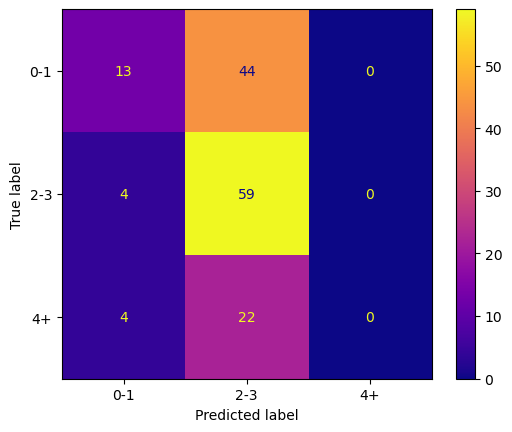

In [813]:
metrics.ConfusionMatrixDisplay(metrics.confusion_matrix(y_test, y_pred_test)).plot(cmap='plasma')                                                                             
labels=['0-1','2-3','4+']
plt.xticks(ticks=range(len(labels)), labels=labels)
plt.yticks(ticks=range(len(labels)), labels=labels)
plt.show()


In [782]:
pd.Series(best_rf.predict(X_test)).value_counts()

B    125
A     21
Name: count, dtype: int64

In [818]:
df_model = X_train.copy()

In [820]:
df_model[['prob_A','prob_B','prob_C']] = best_rf.predict_proba(df_model)

In [822]:
df_model.head()

,day_of_week,temp,dew,humidity,precip,precipprob,snow,snowdepth,windspeed,winddir,sealevelpressure,cloudcover,visibility,solarradiation,uvindex,moonphase,"preciptype_rain,snow",preciptype_snow,conditions_Overcast,conditions_Partially cloudy,conditions_Rain,"conditions_Rain, Overcast","conditions_Rain, Partially cloudy","conditions_Snow, Rain","conditions_Snow, Rain, Overcast","conditions_Snow, Rain, Partially cloudy",icon_cloudy,icon_partly-cloudy-day,icon_rain,icon_snow,prob_A,prob_B,prob_C
247,8,16.7,14.7,88.7,0.000,0,0.0,0.0,15.3,79.7,1020.2,48.3,5.9,426.4,6,0.95,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0.368896,0.442599,0.188505
335,5,2.2,-1.8,75.3,0.123,100,0.0,0.0,21.0,300.0,1013.0,36.6,14.5,159.5,2,0.94,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0.334184,0.416199,0.249617
702,8,2.9,1.4,89.8,0.034,100,0.0,0.0,27.2,56.5,1016.4,96.4,8.6,6.8,0,0.37,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0.505658,0.346849,0.147493
440,5,7.0,4.3,83.9,0.168,100,0.0,0.0,24.9,238.9,1031.9,43.9,21.6,136.5,6,0.47,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0.299995,0.421002,0.279003
136,2,10.6,8.3,86.4,1.224,100,0.0,0.0,30.1,265.6,1005.7,58.5,12.2,496.3,7,0.19,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0.304561,0.417433,0.278006


In [827]:
df_model[df_model['prob_A']<=df_model['prob_C']]

,day_of_week,temp,dew,humidity,precip,precipprob,snow,snowdepth,windspeed,winddir,sealevelpressure,cloudcover,visibility,solarradiation,uvindex,moonphase,"preciptype_rain,snow",preciptype_snow,conditions_Overcast,conditions_Partially cloudy,conditions_Rain,"conditions_Rain, Overcast","conditions_Rain, Partially cloudy","conditions_Snow, Rain","conditions_Snow, Rain, Overcast","conditions_Snow, Rain, Partially cloudy",icon_cloudy,icon_partly-cloudy-day,icon_rain,icon_snow,prob_A,prob_B,prob_C
581,6,15.4,7.5,60.3,0.000,0,0.0,0.0,28.3,301.7,1023.8,38.7,13.0,260.4,8,0.25,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0.238370,0.421800,0.339830
108,2,9.3,1.7,61.8,0.000,0,0.0,0.0,12.3,165.6,1020.6,11.5,11.4,529.0,8,0.24,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.297513,0.401649,0.300839
584,2,20.0,11.3,59.8,0.000,0,0.0,0.0,16.1,13.6,1027.0,2.5,11.9,285.8,8,0.37,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.241603,0.431074,0.327323
532,6,20.2,12.8,63.5,0.000,0,0.0,0.0,24.1,214.2,1019.8,10.8,11.5,314.8,8,0.60,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.258474,0.445181,0.296345
104,5,5.0,-2.0,62.3,0.000,0,0.0,0.0,18.9,64.0,1032.7,36.6,14.5,363.4,9,0.11,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0.279801,0.410098,0.310101
537,4,19.3,11.7,63.4,0.000,0,0.0,0.0,17.6,35.9,1013.4,8.4,12.1,317.9,8,0.77,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.254982,0.449192,0.295826
89,4,15.2,6.5,56.9,0.000,0,0.0,0.0,11.0,151.5,1019.6,9.4,10.5,411.1,5,0.59,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.239288,0.431492,0.329220
446,4,10.7,1.3,55.8,0.000,0,0.0,0.0,16.0,103.5,1028.7,1.1,10.9,168.5,6,0.69,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.236053,0.437196,0.326751
588,6,24.9,10.7,43.4,0.000,0,0.0,0.0,18.7,72.9,1018.2,0.1,12.2,269.5,8,0.50,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.242155,0.422273,0.335572
585,3,21.3,11.5,56.1,0.000,0,0.0,0.0,16.2,44.1,1028.4,0.5,11.9,282.2,8,0.41,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.246057,0.420817,0.333126


In [815]:
best_rf.predict_proba(X_test)

array([[0.3750287 , 0.37436261, 0.25060869],
       [0.4028007 , 0.39211732, 0.20508198],
       [0.41164593, 0.41866359, 0.16969048],
       [0.35119294, 0.40546238, 0.24334467],
       [0.30288812, 0.42355285, 0.27355904],
       [0.30951948, 0.41800162, 0.2724789 ],
       [0.40291027, 0.40051788, 0.19657185],
       [0.34979668, 0.40518582, 0.24501749],
       [0.30454706, 0.42039295, 0.27505999],
       [0.36335532, 0.40297338, 0.2336713 ],
       [0.4456463 , 0.38798106, 0.16637264],
       [0.36855388, 0.46049356, 0.17095257],
       [0.42591099, 0.40245743, 0.17163158],
       [0.34097567, 0.43498574, 0.22403859],
       [0.43332225, 0.3949512 , 0.17172655],
       [0.43901164, 0.38937345, 0.17161491],
       [0.36776021, 0.43683934, 0.19540045],
       [0.35895719, 0.40302529, 0.23801752],
       [0.24187002, 0.42358357, 0.33454641],
       [0.3107725 , 0.41161151, 0.27761599],
       [0.37671203, 0.36172352, 0.26156445],
       [0.34745339, 0.42861619, 0.22393041],
       [0.

### Using RF with buckets go 2

In [459]:
rf2 = RF() # Random Forests

#Selecting parameters to vary
rf_params = {
    'n_estimators': [75,100,150], 
    'max_depth': [1,2],
    'max_features':[7,8,9],
    'min_samples_split': [10],
    'min_samples_leaf': [2],
    'bootstrap': [True, False]
}

# Create a grid search object
gs2 = GridSearchCV(rf2, param_grid=rf_params, cv=5, verbose = 1) 

# Fit grid search on the training set
gs2.fit(X_train, y_train)

Fitting 5 folds for each of 36 candidates, totalling 180 fits


GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'bootstrap': [True, False], 'max_depth': [1, 2],
                         'max_features': [7, 8, 9], 'min_samples_leaf': [2],
                         'min_samples_split': [10],
                         'n_estimators': [75, 100, 150]},
             verbose=1)

In [460]:
gs2.best_score_

0.42634836427939876

In [463]:
best_rf = gs2.best_estimator_
best_rf

RandomForestClassifier(max_depth=2, max_features=7, min_samples_leaf=2,
                       min_samples_split=10, n_estimators=75)

In [465]:
results = X_train.copy()
y_pred = best_rf.predict(results)
results['y_pred'] = y_pred
results['y_real'] = y

In [467]:
test_results = X_test.copy()
y_pred_test=best_rf.predict(X_test)
test_results['y_pred'] = y_pred_test
test_results['y_real'] = y_test

In [469]:
apr(y_pred_test, y_test)

Accuracy:0.4863013698630137


In [471]:
apr(y_pred, y_train)

Accuracy:0.4743150684931507


### Using logistic regression

In [475]:
crash_weat_ohe.head(3)

,date,total crashes,tempmax,tempmin,temp,feelslikemax,feelslikemin,feelslike,dew,humidity,precip,precipprob,precipcover,snow,snowdepth,windgust,windspeed,winddir,sealevelpressure,cloudcover,visibility,solarradiation,solarenergy,uvindex,sunrise,sunset,moonphase,description,day_of_week,"preciptype_rain,snow",preciptype_snow,conditions_Overcast,conditions_Partially cloudy,conditions_Rain,"conditions_Rain, Overcast","conditions_Rain, Partially cloudy","conditions_Snow, Rain","conditions_Snow, Rain, Overcast","conditions_Snow, Rain, Partially cloudy",icon_cloudy,icon_partly-cloudy-day,icon_rain,icon_snow,bucket
0,2021-01-01,0.0,3.0,-1.3,1.1,0.0,-3.2,-1.2,0.3,94.6,0.326,100,8.33,0.0,0.0,26.3,14.5,348.0,1012.0,74.3,10.3,314.2,27.2,1,2021-01-01T08:15:50,2021-01-01T16:12:30,0.58,Partly cloudy throughout the day with rain or ...,6,1,0,0,0,0,0,0,0,0,1,0,0,1,0,A
1,2021-01-02,0.0,3.0,-1.0,1.1,1.0,-5.4,-1.9,-0.1,91.8,0.681,100,12.50,0.0,0.0,24.8,21.4,337.1,1016.4,64.6,11.2,146.0,12.6,2,2021-01-02T08:15:41,2021-01-02T16:13:35,0.62,Partly cloudy throughout the day with rain or ...,7,1,0,0,0,0,0,0,0,0,1,0,0,1,0,A
2,2021-01-03,1.0,3.1,0.0,1.7,0.0,-4.5,-2.7,1.4,97.6,0.286,100,12.50,0.0,0.0,37.8,26.7,30.9,1017.6,95.8,8.2,298.3,25.8,1,2021-01-03T08:15:30,2021-01-03T16:14:43,0.65,Cloudy skies throughout the day with a chance ...,8,1,0,0,0,0,0,0,0,1,0,0,0,1,0,A


In [477]:
crash_weat_ohe.columns

Index(['date', 'total crashes', 'tempmax', 'tempmin', 'temp', 'feelslikemax',
       'feelslikemin', 'feelslike', 'dew', 'humidity', 'precip', 'precipprob',
       'precipcover', 'snow', 'snowdepth', 'windgust', 'windspeed', 'winddir',
       'sealevelpressure', 'cloudcover', 'visibility', 'solarradiation',
       'solarenergy', 'uvindex', 'sunrise', 'sunset', 'moonphase',
       'description', 'day_of_week', 'preciptype_rain,snow', 'preciptype_snow',
       'conditions_Overcast', 'conditions_Partially cloudy', 'conditions_Rain',
       'conditions_Rain, Overcast', 'conditions_Rain, Partially cloudy',
       'conditions_Snow, Rain', 'conditions_Snow, Rain, Overcast',
       'conditions_Snow, Rain, Partially cloudy', 'icon_cloudy',
       'icon_partly-cloudy-day', 'icon_rain', 'icon_snow', 'bucket'],
      dtype='object')

In [483]:
lr_cols= [ 'temp', 'precip', 'snow', 'windspeed', 
       'sealevelpressure', 'cloudcover', 'visibility', 'solarradiation',
         'moonphase', 'preciptype_rain,snow', 'preciptype_snow',
       'conditions_Overcast', 'conditions_Partially cloudy', 'conditions_Rain',
       'conditions_Rain, Overcast', 'conditions_Rain, Partially cloudy',
       'conditions_Snow, Rain', 'conditions_Snow, Rain, Overcast',
       'conditions_Snow, Rain, Partially cloudy', 'icon_cloudy',
       'icon_partly-cloudy-day', 'icon_rain', 'icon_snow', 'bucket']

In [551]:
cw = crash_weat_ohe[lr_cols]

In [553]:
from sklearn.preprocessing import MinMaxScaler

In [555]:
cols = ['temp', 'precip', 'snow', 'windspeed', 
       'sealevelpressure', 'cloudcover', 'visibility', 'solarradiation',
         'moonphase']
minmax = MinMaxScaler()  #set up the scaler
minmax.fit(cw[cols])

MinMaxScaler()

In [557]:
def scaling(df):
    df = df.copy()
    df = df.reset_index(drop=True) #reset the index of original df
    cols = ['temp', 'precip', 'snow', 'windspeed', 
       'sealevelpressure', 'cloudcover', 'visibility', 'solarradiation',
         'moonphase']
    scaled_cols = minmax.transform(df[cols]) #using thescaler on the desired columns
    scaled_cols_df = pd.DataFrame(scaled_cols, columns = ['temp_scal', 'precip_scal', 'snow_scal', 'windspeed_scal', 
       'sealevelpressure_scal', 'cloudcover_scal', 'visibility_scal', 'solarradiation_scal',
         'moonphase_scal']) #turn the scaled info into a dataframe
    df = df.join(scaled_cols_df) #join the scaled results to the end now that the indices match
    df.drop(columns=cols, inplace = True)
    return df

In [559]:
scaling(cw)

,"preciptype_rain,snow",preciptype_snow,conditions_Overcast,conditions_Partially cloudy,conditions_Rain,"conditions_Rain, Overcast","conditions_Rain, Partially cloudy","conditions_Snow, Rain","conditions_Snow, Rain, Overcast","conditions_Snow, Rain, Partially cloudy",icon_cloudy,icon_partly-cloudy-day,icon_rain,icon_snow,bucket,temp_scal,precip_scal,snow_scal,windspeed_scal,sealevelpressure_scal,cloudcover_scal,visibility_scal,solarradiation_scal,moonphase_scal
0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,A,0.121951,0.014303,0.0,0.124150,0.483186,0.743,0.2575,0.514135,0.591837
1,1,0,0,0,0,0,0,0,0,1,0,0,1,0,A,0.121951,0.029879,0.0,0.241497,0.561062,0.646,0.2800,0.236072,0.632653
2,1,0,0,0,0,0,0,0,1,0,0,0,1,0,A,0.142857,0.012548,0.0,0.331633,0.582301,0.958,0.2050,0.487849,0.663265
3,0,0,0,1,0,0,0,0,0,0,0,1,0,0,B,0.160279,0.000000,0.0,0.409864,0.630088,0.888,0.3100,0.595966,0.704082
4,0,0,0,1,0,0,0,0,0,0,0,1,0,0,B,0.132404,0.000000,0.0,0.416667,0.653097,0.812,0.3550,0.220367,0.744898
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
725,0,0,0,0,0,0,1,0,0,0,0,0,1,0,A,0.327526,0.141146,0.0,0.355442,0.569912,0.774,0.2400,0.016697,0.142857
726,0,0,0,0,0,1,0,0,0,0,0,0,1,0,A,0.414634,0.150535,0.0,0.511905,0.265487,0.945,0.2300,0.013721,0.173469
727,0,0,0,0,0,0,1,0,0,0,0,0,1,0,A,0.306620,0.256143,0.0,0.414966,0.274336,0.630,0.2475,0.034551,0.214286
728,0,0,0,0,0,0,1,0,0,0,0,0,1,0,A,0.397213,0.147464,0.0,0.540816,0.169912,0.666,0.2475,0.024467,0.255102


In [561]:
X= cw[['temp', 'precip', 'snow', 'windspeed', 'sealevelpressure', 'cloudcover',
       'visibility', 'solarradiation', 'moonphase', 'preciptype_rain,snow',
       'preciptype_snow', 'conditions_Overcast', 'conditions_Partially cloudy',
       'conditions_Rain', 'conditions_Rain, Overcast',
       'conditions_Rain, Partially cloudy', 'conditions_Snow, Rain',
       'conditions_Snow, Rain, Overcast',
       'conditions_Snow, Rain, Partially cloudy', 'icon_cloudy',
       'icon_partly-cloudy-day', 'icon_rain', 'icon_snow']]
y= cw['bucket']

In [563]:
X.head()

,temp,precip,snow,windspeed,sealevelpressure,cloudcover,visibility,solarradiation,moonphase,"preciptype_rain,snow",preciptype_snow,conditions_Overcast,conditions_Partially cloudy,conditions_Rain,"conditions_Rain, Overcast","conditions_Rain, Partially cloudy","conditions_Snow, Rain","conditions_Snow, Rain, Overcast","conditions_Snow, Rain, Partially cloudy",icon_cloudy,icon_partly-cloudy-day,icon_rain,icon_snow
0,1.1,0.326,0.0,14.5,1012.0,74.3,10.3,314.2,0.58,1,0,0,0,0,0,0,0,0,1,0,0,1,0
1,1.1,0.681,0.0,21.4,1016.4,64.6,11.2,146.0,0.62,1,0,0,0,0,0,0,0,0,1,0,0,1,0
2,1.7,0.286,0.0,26.7,1017.6,95.8,8.2,298.3,0.65,1,0,0,0,0,0,0,0,1,0,0,0,1,0
3,2.2,0.000,0.0,31.3,1020.3,88.8,12.4,363.7,0.69,0,0,0,1,0,0,0,0,0,0,0,1,0,0
4,1.4,0.000,0.0,31.7,1021.6,81.2,14.2,136.5,0.73,0,0,0,1,0,0,0,0,0,0,0,1,0,0


In [565]:
y.head()

0    A
1    A
2    A
3    B
4    B
Name: bucket, dtype: object

In [648]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [650]:
from sklearn.linear_model import LogisticRegression

In [651]:
logreg= LogisticRegression(max_iter = 4000, multi_class='multinomial'
                           #, solver='lbfgs'
                          )

In [654]:
logreg.fit(X_train,y_train)

LogisticRegression(max_iter=4000, multi_class='multinomial')

In [655]:
y_pred_train = logreg.predict(X_train)

In [658]:
X_train['y_pred_train'] = y_pred_train

In [659]:
X_train.head()

,temp,precip,snow,windspeed,sealevelpressure,cloudcover,visibility,solarradiation,moonphase,"preciptype_rain,snow",preciptype_snow,conditions_Overcast,conditions_Partially cloudy,conditions_Rain,"conditions_Rain, Overcast","conditions_Rain, Partially cloudy","conditions_Snow, Rain","conditions_Snow, Rain, Overcast","conditions_Snow, Rain, Partially cloudy",icon_cloudy,icon_partly-cloudy-day,icon_rain,icon_snow,y_pred_train
247,16.7,0.000,0.0,15.3,1020.2,48.3,5.9,426.4,0.95,0,0,0,1,0,0,0,0,0,0,0,1,0,0,C
335,2.2,0.123,0.0,21.0,1013.0,36.6,14.5,159.5,0.94,0,0,0,0,0,0,1,0,0,0,0,0,1,0,B
702,2.9,0.034,0.0,27.2,1016.4,96.4,8.6,6.8,0.37,0,0,0,0,0,1,0,0,0,0,0,0,1,0,A
440,7.0,0.168,0.0,24.9,1031.9,43.9,21.6,136.5,0.47,0,0,0,0,0,0,1,0,0,0,0,0,1,0,B
136,10.6,1.224,0.0,30.1,1005.7,58.5,12.2,496.3,0.19,0,0,0,0,0,0,1,0,0,0,0,0,1,0,B


In [662]:
cm = metrics.confusion_matrix(y_train, X_train['y_pred_train'])
cm

array([[ 68, 125,  11],
       [ 49, 185,   8],
       [ 40,  84,  14]], dtype=int64)

In [664]:
def get_results(actual, predicted):
    print("The confusion matrix for your predictions is:")
    print(metrics.confusion_matrix(actual, predicted), "\n")
    print(f'The accuracy of your model is: {metrics.accuracy_score(actual, predicted)}')

In [636]:
get_results(y_train, X_train['y_pred_train'])

The confusion matrix for your predictions is:
[[ 68 125  11]
 [ 49 185   8]
 [ 40  84  14]] 

The accuracy of your model is: 0.4571917808219178


In [638]:
y_pred_test = logreg.predict(X_test)

In [640]:
# X_test['y_pred_test'] = y_pred_test

In [642]:
get_results(y_test, X_test['y_pred_test'])

The confusion matrix for your predictions is:
[[22 32  3]
 [17 38  8]
 [ 2 24  0]] 

The accuracy of your model is: 0.410958904109589


This is no better than the RF so will stick to that model

In [676]:
logreg.predict_proba(X_test)

array([[0.39152297, 0.42642075, 0.18205628],
       [0.33578452, 0.31868034, 0.34553514],
       [0.28890131, 0.40459524, 0.30650346],
       [0.38606958, 0.3671528 , 0.24677762],
       [0.33855486, 0.45784239, 0.20360276],
       [0.32783098, 0.40034695, 0.27182207],
       [0.41680587, 0.28670939, 0.29648474],
       [0.44260516, 0.31778169, 0.23961314],
       [0.36460267, 0.36635597, 0.26904136],
       [0.36987686, 0.39342014, 0.23670299],
       [0.42756339, 0.27320197, 0.29923464],
       [0.38674658, 0.56359006, 0.04966336],
       [0.29758331, 0.62381589, 0.0786008 ],
       [0.33759506, 0.53247707, 0.12992787],
       [0.35516043, 0.42953978, 0.21529979],
       [0.44168647, 0.29979165, 0.25852188],
       [0.339501  , 0.34684871, 0.3136503 ],
       [0.37613239, 0.39490128, 0.22896633],
       [0.21145362, 0.31671022, 0.47183616],
       [0.34015645, 0.38272221, 0.27712134],
       [0.47062095, 0.33290065, 0.1964784 ],
       [0.34792027, 0.47534774, 0.176732  ],
       [0.

In [672]:
pd.Series(logreg.predict(X_test)).value_counts()

B    94
A    41
C    11
Name: count, dtype: int64